Some testing on a sin wave pattern to establish an LSTM's ability to predict

Much of the code based off this tutorial here: https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7

In [36]:
import numpy as np # Standard python maths library

import matplotlib.pyplot as plt # Graph plotting tools
plt.rcParams['figure.figsize'] = [20, 5] # matplotlib settings, define size of graph. Edit if the graphs do not fit on your screen
plt.show()

import torch # Machine learning libary being used for LSTM
from torch import nn # Commonly used module of torch library

from sklearn.metrics import mean_squared_error

import random

import statsmodels.api as sm

In [2]:
def RMSE(x, y):
    return np.sqrt(np.mean((x - y)**2))

Building a noisy sine wave to get a pattern for SARIMA and LSTM to solve

In [3]:
np.random.seed(100)
random.seed(100)

N = 3000 # number of samples
T = 20 # width of the wave
stDev = 0.5 # Strength of noise


x = np.arange(N) / N
base_y = np.sin(np.arange(N)/1.0/T).astype(np.float32) # Pure sin wave
y = base_y + np.random.normal(loc=0, scale=stDev, size=N) # Add noise to sample

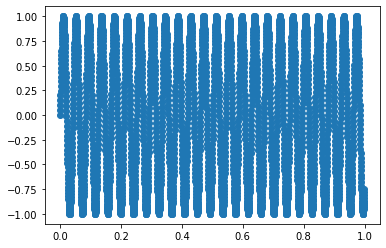

In [4]:
# Plot of pure sin wave
plt.scatter(x, base_y)

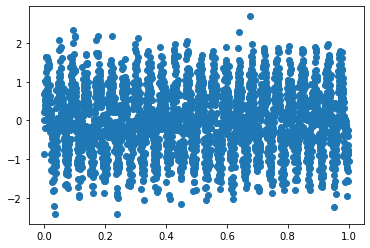

In [5]:
# Plot of the pure sin wave with added noise
plt.scatter(x, y)

In [6]:
sinResults = {}

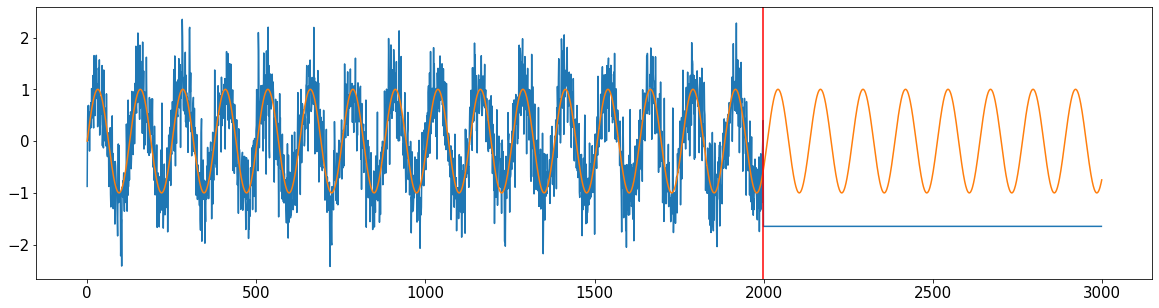

In [47]:
def predict_last(data, future=0):
    out = []
    for i in range(1, len(data)):
        out.append(data[i-1])
    
    out += [data[-1]] * future
    
    return out

future_holdout = 1000

results = predict_last(y[:-future_holdout], future=1000)
plt.plot(results)
plt.plot(base_y)
plt.axvline(x=len(results)-future_holdout, c="r")

0.5139037388964983
0.5139037388964983


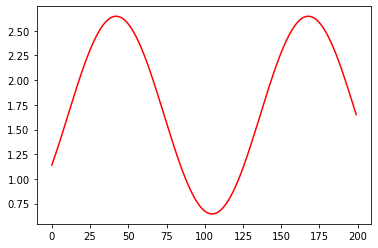

In [8]:
bigPred = results

presentPred = bigPred[:-future_holdout]
futurePred = bigPred[-future_holdout:]

presentTrue = base_y[1:-future_holdout]
futureTrue = base_y[-future_holdout+1:]

error = np.sqrt(np.mean((presentPred - presentTrue)**2))
print(error)
print(RMSE(presentPred, presentTrue))

futureErrorWindow = 200
futureTrue = base_y[-future_holdout:]
futureErrors = abs(futurePred[:futureErrorWindow] - futureTrue[:futureErrorWindow])
plt.plot(futureErrors, color="r")

results = {
    "Full Prediction" : bigPred,
    "RMSE" : error, 
    "FutureErrors" : futureErrors,
}

sinResults["PreviousValue"] = results


# plt.plot(res.fittedvalues,  color="r")
# plt.plot(base_y)
# plt.plot(res.predict(start=0, end=3000))



In [9]:
future_holdout = 1000

model = sm.tsa.arima.ARIMA(endog=np.array(y[:-future_holdout]), order=(1, 0, 1), seasonal_order=(1, 0, 1, 100))
res = model.fit()

0.2183428314298283
0.2183428314298283


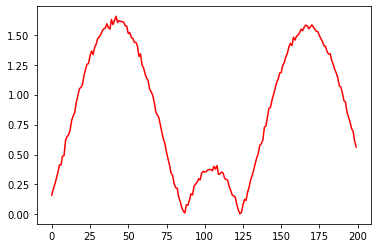

In [10]:
bigPred = res.predict(start=1, end=3000)

presentPred = bigPred[:-future_holdout]
futurePred = bigPred[-future_holdout:]

presentTrue = base_y[:-future_holdout]
futureTrue = base_y[-future_holdout:]

error = np.sqrt(np.mean((presentPred - presentTrue)**2))
print(error)
print(RMSE(presentPred, presentTrue))

futureErrorWindow = 200
futureTrue = base_y[-future_holdout:]
futureErrors = abs(futurePred[:futureErrorWindow] - futureTrue[:futureErrorWindow])
plt.plot(futureErrors, color="r")

results = {
    "Full Prediction" : bigPred,
    "RMSE" : error, 
    "FutureErrors" : futureErrors,
}

sinResults["SARIMA"] = results


# plt.plot(res.fittedvalues,  color="r")
# plt.plot(base_y)
# plt.plot(res.predict(start=0, end=3000))



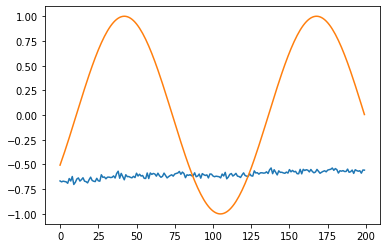

In [11]:
plt.plot(sinResults["SARIMA"]["Full Prediction"][-1000:-800])
plt.plot(base_y[-1000:-800])

In [12]:
len(res.predict(start=0, end=3000))

3001

Building the LSTM occurs in multiple parts
 - Build the LSTM class
 - Build a training loop
 - Prepare the data
 
Firstly, building the LSTM class:

In [13]:
class LSTM_multifeature(nn.Module):
    def __init__(self, input_features, hidden_lstm_layers=[32]):
        """ Instantiate the LSTM with multiple hidden layers
            This version can construct a model with an abritrary number of hidden layers, of arbritrary size """
        super(LSTM_multifeature, self).__init__()
        self.input_features = input_features
        self.hidden_lstm_layers = hidden_lstm_layers
        self.lstm_layers = []
        layer_counts = [input_features] + hidden_lstm_layers
        
        for i in range(len(layer_counts)-1):
            self.lstm_layers.append(nn.LSTMCell(layer_counts[i], layer_counts[i+1]))
        
        self.out_layer = nn.Linear(layer_counts[-1], 1)
        
        self.last_loss = 0  # For printing purposes during training
        
    def forward(self, y, future_preds=0):
        """ Call the model to make predictions
            h_t and c_t are the hidden and cell states of the lstm layers
            
            This forward function runs through the data one point at a time, and stores the models output for each point
            If future_preds > 0 is passed in, the model with make predictions based on its own output. It is currently very bad at this.
        """
        outputs, num_samples = [], y.shape[0]
        
        h_t = [None] + [torch.zeros(1, n,  dtype=torch.float32) for n in self.hidden_lstm_layers]
        c_t = [torch.zeros(1, n,  dtype=torch.float32) for n in self.hidden_lstm_layers]
        
        for time_step in y.split(1, dim=0):
            h_t[0] = time_step
            for i in range(len(c_t)):
                h_t[i+1], c_t[i] = self.lstm_layers[i](h_t[i], (h_t[i+1], c_t[i])) # initial hidden and cell states
            
            output = self.out_layer(h_t[-1]) # output from the last FC layer
            outputs.append(output)
        
        new_input = torch.cat([time_step[0], output[0]], dim=0)[1:].reshape(1, self.input_features)
        for i in range(future_preds):
            h_t[0] = new_input
            for i in range(len(c_t)):
                h_t[i+1], c_t[i] = self.lstm_layers[i](h_t[i], (h_t[i+1], c_t[i])) # initial hidden and cell states
            
            output = self.out_layer(h_t[-1])

            new_input = torch.cat([new_input[0], output[0]], dim=0)[1:].reshape(1, self.input_features)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

    
def training_loop_multifeature(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target, 
                  num_batches=1, min_batch_length=100, random_seed=100):
    """ Train a model with provided data
        Ignorning the auto plotting part for now """
    
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    for i in range(n_epochs):
        if num_batches > 1:
            while True:
                batchIndices = sorted([0] + [random.randint(0, len(train_input)) for x in range(num_batches-1)] + [len(train_input)])
                min_batch = min([y-x for x, y in zip(batchIndices[:-1], batchIndices[1:])])
                if min_batch >= min_batch_length:
                    break
            batches, batchY = [], []
            for n in range(num_batches):
                batches.append((train_input[batchIndices[n]:batchIndices[n+1]],
                                train_target[batchIndices[n]:batchIndices[n+1]]))
        else:
            batches = [(train_input, train_target)]
            batchIndices = None
        
        print("Epoch: ", i, ", Batch Indicies: ", batchIndices)
        random.shuffle(batches)
        for x, y in batches:
            def closure():
                optimiser.zero_grad()
                out = model(x)
                out = out.reshape(out.shape[1])
                loss = loss_fn(out, y)
                loss.backward()
                model.last_loss = loss
                return loss
            
            optimiser.step(closure)
            print("Loss: ", model.last_loss)
        
    # Make future predictions
    if len(test_input) > 0:
        with torch.no_grad():
            future = len(test_target)
            pred = model(torch.cat([train_input, test_input], dim=0), future_preds=future)
            print(pred.shape)
            print(pred)
            loss = loss_fn(pred.reshape(pred.shape[1])[-future:], test_target)
            y = pred.detach().numpy()
    else:
        loss, y = None, None

    return (loss, y)

Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.5690, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.3244, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.3195, grad_fn=<MseLossBackward0>)
Epoch:  3 , Batch Indicies:  None
Loss:  tensor(0.3159, grad_fn=<MseLossBackward0>)
Epoch:  4 , Batch Indicies:  None
Loss:  tensor(0.3154, grad_fn=<MseLossBackward0>)
Epoch:  5 , Batch Indicies:  None
Loss:  tensor(0.3142, grad_fn=<MseLossBackward0>)
Epoch:  6 , Batch Indicies:  None
Loss:  tensor(0.3142, grad_fn=<MseLossBackward0>)
Epoch:  7 , Batch Indicies:  None
Loss:  tensor(0.3142, grad_fn=<MseLossBackward0>)
Epoch:  8 , Batch Indicies:  None
Loss:  tensor(0.3142, grad_fn=<MseLossBackward0>)
Epoch:  9 , Batch Indicies:  None
Loss:  tensor(0.3142, grad_fn=<MseLossBackward0>)


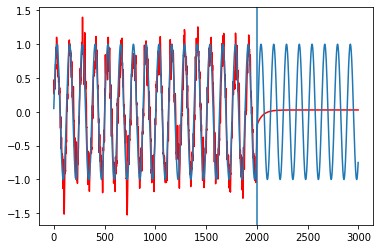

In [14]:
num_features = 1
num_samples = len(y)

test_size = 0
future_holdout = 1000

windowData = np.array(y[:num_features+1])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, y[i:i+num_features+1]))

trainData = windowData[:-(test_size+future_holdout)]
testData = windowData[-(test_size+future_holdout):-future_holdout]

newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)

model = LSTM_multifeature(input_features=num_features, hidden_lstm_layers=[32, 32, 32])
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.3)
# optimiser = torch.optim.Adam(model.parameters(), lr=0.3)


# Train the model
r = training_loop_multifeature(10, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY, num_batches=1, random_seed=100)

with torch.no_grad():
    future = 1000
    pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
    bigPred = pred[0].detach().numpy()

plt.plot(bigPred, color="r")
plt.plot(base_y[num_features:])
# plt.axvline(x=900)
plt.axvline(x=2000)
plt.show()

0.22547817
0.22547817


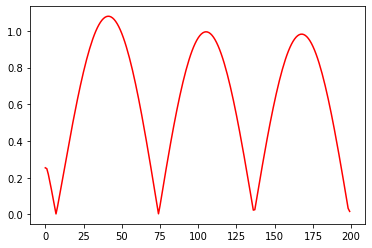

In [15]:
presentPred = bigPred[:-future_holdout]
futurePred = bigPred[-future_holdout:]

presentTrue = base_y[num_features:-future_holdout]
futureTrue = base_y[-future_holdout:]

error = np.sqrt(np.mean((presentPred - presentTrue)**2))
print(error)
print(RMSE(presentPred, presentTrue))

futureErrorWindow = 200
futureErrors = abs(futurePred[:futureErrorWindow] - futureTrue[:futureErrorWindow])
plt.plot(futureErrors, color="r")

results = {
    "Full Prediction" : bigPred,
    "RMSE" : error, 
    "FutureErrors" : futureErrors,
}

sinResults["SingleFeature"] = results

Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.4599, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.3272, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.3155, grad_fn=<MseLossBackward0>)
Epoch:  3 , Batch Indicies:  None
Loss:  tensor(0.3046, grad_fn=<MseLossBackward0>)
Epoch:  4 , Batch Indicies:  None
Loss:  tensor(0.2993, grad_fn=<MseLossBackward0>)
Epoch:  5 , Batch Indicies:  None
Loss:  tensor(0.2949, grad_fn=<MseLossBackward0>)
Epoch:  6 , Batch Indicies:  None
Loss:  tensor(0.2946, grad_fn=<MseLossBackward0>)
Epoch:  7 , Batch Indicies:  None
Loss:  tensor(0.2920, grad_fn=<MseLossBackward0>)
Epoch:  8 , Batch Indicies:  None
Loss:  tensor(0.2907, grad_fn=<MseLossBackward0>)
Epoch:  9 , Batch Indicies:  None
Loss:  tensor(0.2906, grad_fn=<MseLossBackward0>)


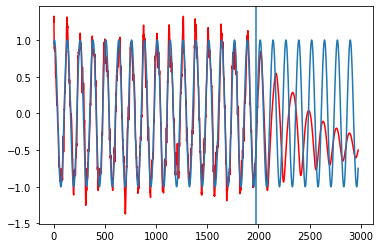

In [16]:
num_features = 25
num_samples = len(y)

test_size = 0
future_holdout = 1000

windowData = np.array(y[:num_features+1])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, y[i:i+num_features+1]))

trainData = windowData[:-(test_size+future_holdout)]
testData = windowData[-(test_size+future_holdout):-future_holdout]

newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)

model = LSTM_multifeature(input_features=num_features, hidden_lstm_layers=[32, 32, 32])
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.3)
# optimiser = torch.optim.Adam(model.parameters(), lr=0.3)


# Train the model
r = training_loop_multifeature(10, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY, num_batches=1, random_seed=100)

with torch.no_grad():
    future = 1000
    pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
    # print(pred[0])
    bigPred = pred[0].detach().numpy()

plt.plot(bigPred, color="r")
plt.plot(base_y[num_features:])
# plt.axvline(x=900)
plt.axvline(x=len(bigPred)-future_holdout)
plt.show()

0.16685107
0.16685107


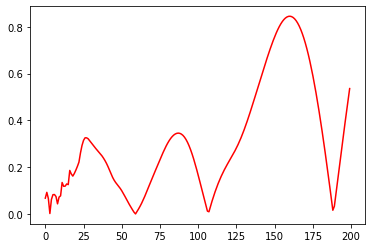

In [17]:
presentPred = bigPred[:-future_holdout]
futurePred = bigPred[-future_holdout:]

presentTrue = base_y[num_features:-future_holdout]
futureTrue = base_y[-future_holdout:]

error = np.sqrt(np.mean((presentPred - presentTrue)**2))
print(error)
print(RMSE(presentPred, presentTrue))

futureErrorWindow = 200
futureErrors = abs(futurePred[:futureErrorWindow] - futureTrue[:futureErrorWindow])
plt.plot(futureErrors, color="r")
                              
results = {
    "Full Prediction" : bigPred,
    "RMSE" : error, 
    "FutureErrors" : futureErrors,
}

sinResults["25Feature"] = results

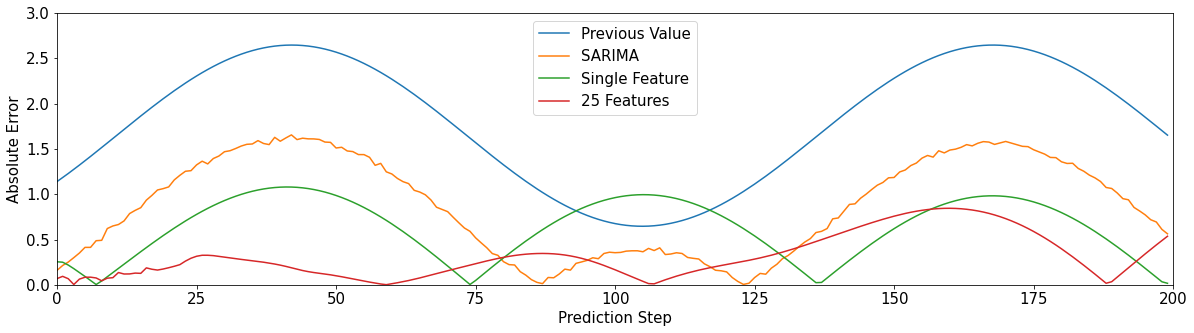

In [50]:
plt.rcParams.update({'font.size': 15})
plt.show()

plt.xlim(0, 200)
plt.ylim(0, 3)


plt.plot(sinResults["PreviousValue"]["FutureErrors"], label="Previous Value")
plt.plot(sinResults["SARIMA"]["FutureErrors"], label="SARIMA")
plt.plot(sinResults["SingleFeature"]["FutureErrors"], label="Single Feature")
plt.plot(sinResults["25Feature"]["FutureErrors"], label="25 Features")
plt.legend(loc='upper center',  prop={'size': 15})


plt.xlabel('Prediction Step')
plt.ylabel('Absolute Error')

plt.show()


Text(0, 0.5, 'Absolute Error')

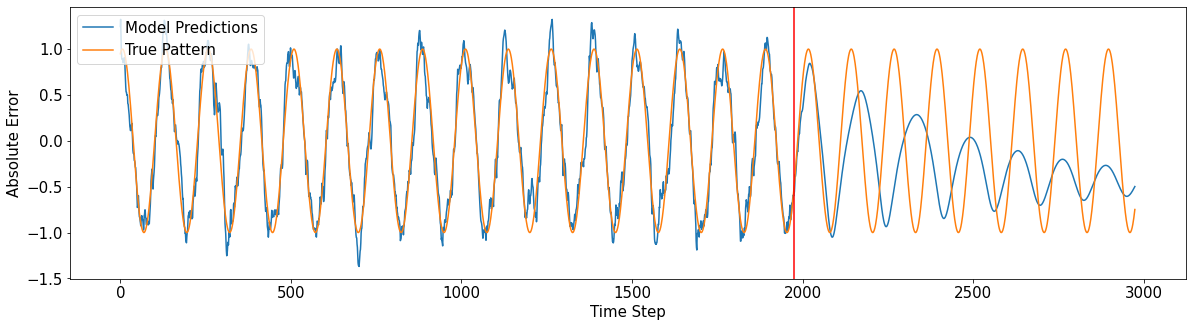

In [46]:
plt.plot(sinResults["25Feature"]["Full Prediction"], label="Model Predictions")
plt.plot(base_y[25:], label="True Pattern")
plt.axvline(x=len(sinResults["25Feature"]["Full Prediction"])-1000, c="r")

plt.legend(loc='upper left',  prop={'size': 15})
plt.xlabel('Time Step')
plt.ylabel('Absolute Error')


In [38]:
for k, v in sinResults.items():
    print(k, v["RMSE"])

PreviousValue 0.5139037388964983
SARIMA 0.2183428314298283
SingleFeature 0.22547817
25Feature 0.16685107


In [51]:
np.random.seed(100)
random.seed(100)

N = 3000 # number of samples
# T1 = 20 # width of the wave
# M1 = 1

# T2 = 7
# M2 = 0.7

# T3 = 25
# M3 = 0.3

T1 = 150 # width of the wave
M1 = 1

T2 = 250
M2 = 1

# T3 = 20
# M3 = 0.3


stDev = 0.35 # Strength of noise
averageMovement = 4


x = np.arange(N) / N
base_y = np.sin(np.arange(N)*M1/T1*12).astype(np.float32)  \
       + np.sin(np.arange(N)*M2/T2*12).astype(np.float32) \
       # + np.sin(np.arange(N)*M3/T3).astype(np.float32)
y = base_y + np.random.normal(loc=0, scale=stDev, size=N) # Add noise to sample

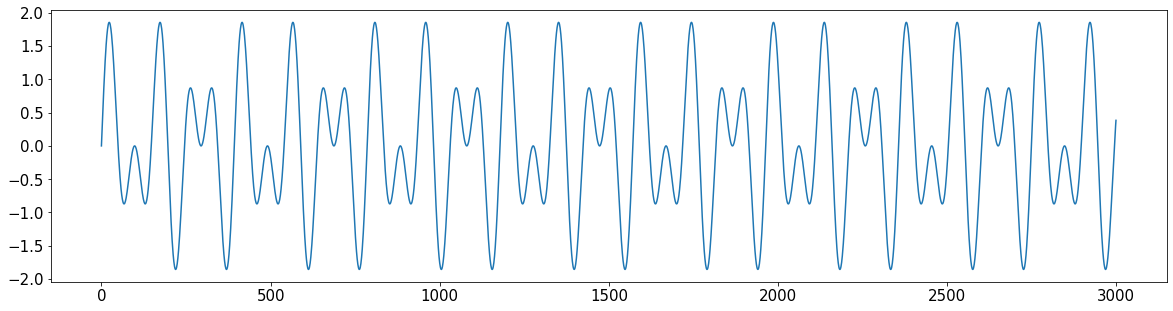

In [52]:
plt.plot(base_y)

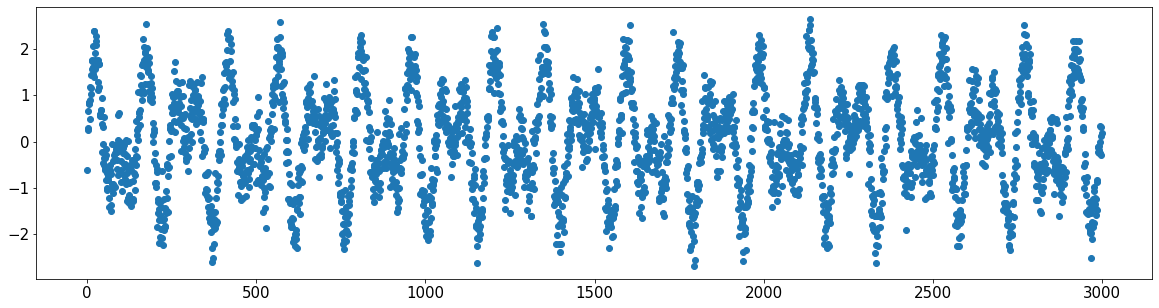

In [53]:
plt.scatter(np.arange(N), y)

In [54]:
fourierResults = {}

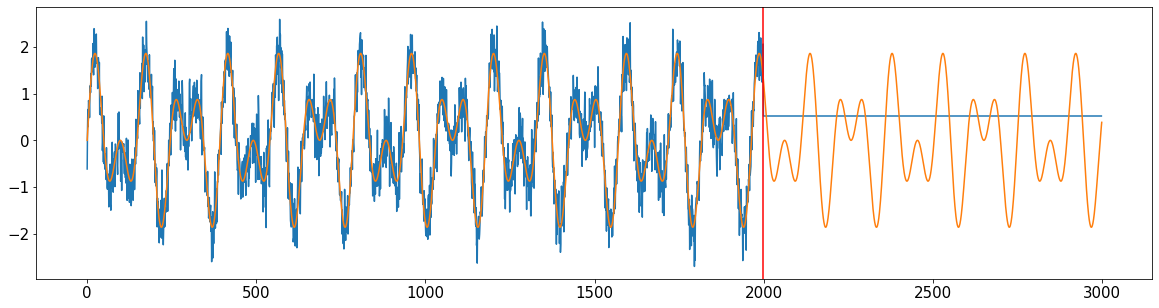

In [55]:
def predict_last(data, future=0):
    out = []
    for i in range(1, len(data)):
        out.append(data[i-1])
    
    out += [data[-1]] * future
    
    return out

future_holdout = 1000

results = predict_last(y[:-future_holdout], future=1000)
plt.plot(results)
plt.plot(base_y)
plt.axvline(x=len(results)-future_holdout, c="r")

0.36684287788813935
0.36684287788813935


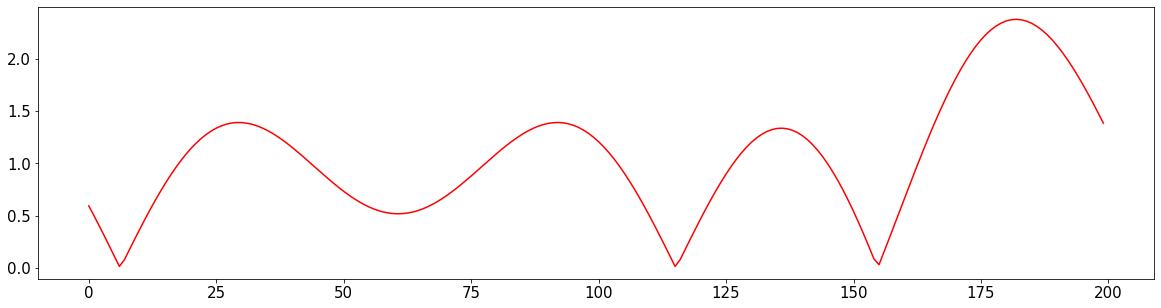

In [56]:
bigPred = results

presentPred = bigPred[:-future_holdout]
futurePred = bigPred[-future_holdout:]

presentTrue = base_y[1:-future_holdout]
futureTrue = base_y[-future_holdout+1:]

error = np.sqrt(np.mean((presentPred - presentTrue)**2))
print(error)
print(RMSE(presentPred, presentTrue))

futureErrorWindow = 200
futureErrors = abs(futurePred[:futureErrorWindow] - futureTrue[:futureErrorWindow])
plt.plot(futureErrors, color="r")

results = {
    "Full Prediction" : bigPred,
    "RMSE" : error, 
    "FutureErrors" : futureErrors,
}

fourierResults["PreviousValue"] = results


In [57]:
SARIMA_start = 1200

future_holdout = 1000

model = sm.tsa.arima.ARIMA(endog=np.array(y[SARIMA_start:-future_holdout]), order=(1, 0, 1), seasonal_order=(1, 0, 1, 400))
res = model.fit()

C:\Users\ray\anaconda3\envs\MscThesis\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\ray\anaconda3\envs\MscThesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


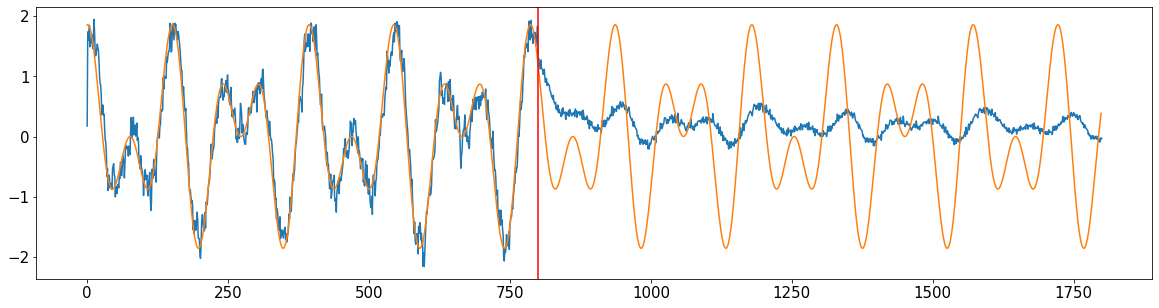

In [58]:
# plt.plot(res.fittedvalues)
plt.plot(res.predict(start=0, end=len(res.fittedvalues)+1000))
plt.plot(base_y[SARIMA_start:])
plt.axvline(x=len(res.fittedvalues), c="r")

0.21059073673810752
0.21059073673810752


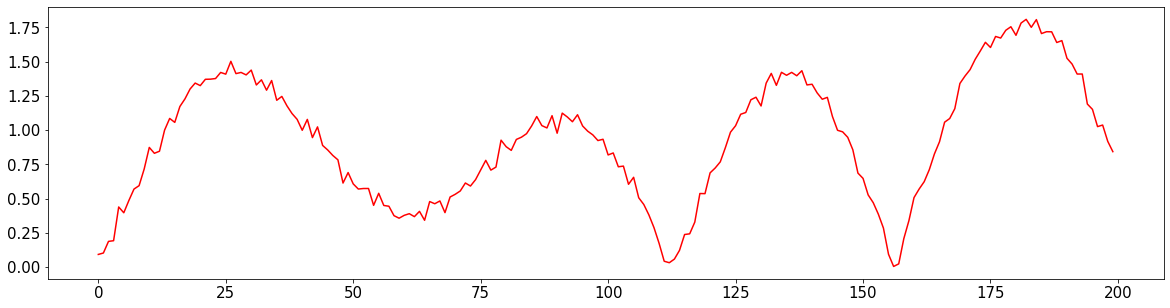

In [61]:
# bigPred = res.predict(start=1, end=3000)
bigPred = res.predict(start=0, end=len(res.fittedvalues)+1000)

presentPred = bigPred[:-future_holdout]
futurePred = bigPred[-future_holdout:]

presentTrue = base_y[SARIMA_start-1:-future_holdout]
futureTrue = base_y[-future_holdout:]

error = np.sqrt(np.mean((presentPred - presentTrue)**2))
print(error)
print(RMSE(presentPred, presentTrue))

futureErrorWindow = 200
# futureTrue = base_y[-future_holdout:]
futureErrors = abs(futurePred[:futureErrorWindow] - futureTrue[:futureErrorWindow])
plt.plot(futureErrors, color="r")

results = {
    "Full Prediction" : bigPred,
    "RMSE" : error, 
    "FutureErrors" : futureErrors,
}

fourierResults["SARIMA"] = results

# plt.plot(bigPred,  color="r")
# plt.plot(base_y[SARIMA_start-1:])
# plt.axvline(x=len(res.fittedvalues), c="r")


Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.4636, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.2505, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.2231, grad_fn=<MseLossBackward0>)
Epoch:  3 , Batch Indicies:  None
Loss:  tensor(0.2128, grad_fn=<MseLossBackward0>)
Epoch:  4 , Batch Indicies:  None
Loss:  tensor(0.2081, grad_fn=<MseLossBackward0>)
Epoch:  5 , Batch Indicies:  None
Loss:  tensor(0.1743, grad_fn=<MseLossBackward0>)
Epoch:  6 , Batch Indicies:  None
Loss:  tensor(0.1743, grad_fn=<MseLossBackward0>)
Epoch:  7 , Batch Indicies:  None
Loss:  tensor(0.1743, grad_fn=<MseLossBackward0>)
Epoch:  8 , Batch Indicies:  None
Loss:  tensor(0.1742, grad_fn=<MseLossBackward0>)
Epoch:  9 , Batch Indicies:  None
Loss:  tensor(0.1732, grad_fn=<MseLossBackward0>)


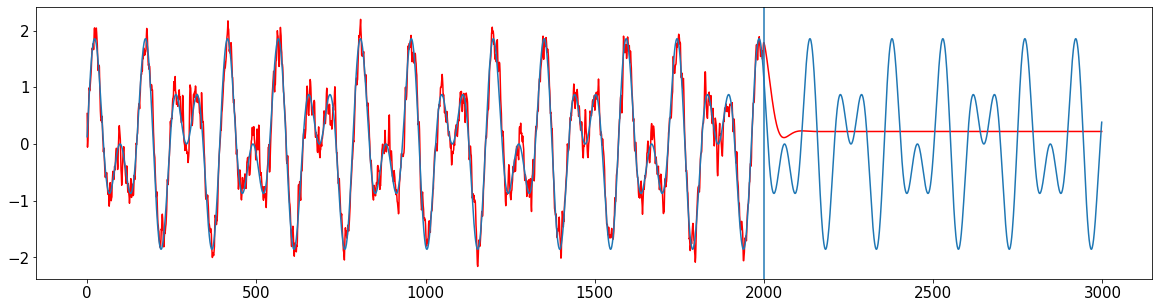

In [62]:
num_features = 1
num_samples = len(y)

test_size = 0
future_holdout = 1000

windowData = np.array(y[:num_features+1])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, y[i:i+num_features+1]))

trainData = windowData[:-(test_size+future_holdout)]
testData = windowData[-(test_size+future_holdout):-future_holdout]

newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)

model = LSTM_multifeature(input_features=num_features, hidden_lstm_layers=[32, 32, 32])
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.3)
# optimiser = torch.optim.Adam(model.parameters(), lr=0.3)

# Train the model
r = training_loop_multifeature(10, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY, num_batches=1, random_seed=100)

with torch.no_grad():
    future = 1000
    pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
    bigPred = pred[0].detach().numpy()

plt.plot(bigPred, color="r")
plt.plot(base_y[num_features:])
# plt.axvline(x=900)
plt.axvline(x=2000)
plt.show()

0.2175221
0.2175221


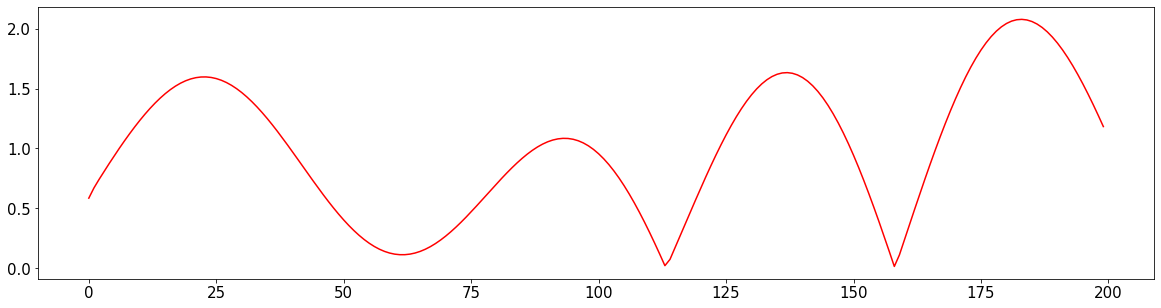

In [63]:
presentPred = bigPred[:-future_holdout]
futurePred = bigPred[-future_holdout:]

presentTrue = base_y[num_features:-future_holdout]
futureTrue = base_y[-future_holdout:]

error = np.sqrt(np.mean((presentPred - presentTrue)**2))
print(error)
print(RMSE(presentPred, presentTrue))

futureErrorWindow = 200
futureErrors = abs(futurePred[:futureErrorWindow] - futureTrue[:futureErrorWindow])
plt.plot(futureErrors, color="r")

results = {
    "Full Prediction" : bigPred,
    "RMSE" : error, 
    "FutureErrors" : futureErrors,
}

fourierResults["SingleFeature"] = results

Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.3457, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.2187, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1983, grad_fn=<MseLossBackward0>)
Epoch:  3 , Batch Indicies:  None
Loss:  tensor(0.1971, grad_fn=<MseLossBackward0>)
Epoch:  4 , Batch Indicies:  None
Loss:  tensor(0.1862, grad_fn=<MseLossBackward0>)
Epoch:  5 , Batch Indicies:  None
Loss:  tensor(0.1835, grad_fn=<MseLossBackward0>)
Epoch:  6 , Batch Indicies:  None
Loss:  tensor(0.1771, grad_fn=<MseLossBackward0>)
Epoch:  7 , Batch Indicies:  None
Loss:  tensor(1.2088, grad_fn=<MseLossBackward0>)
Epoch:  8 , Batch Indicies:  None
Loss:  tensor(0.1748, grad_fn=<MseLossBackward0>)
Epoch:  9 , Batch Indicies:  None
Loss:  tensor(0.1732, grad_fn=<MseLossBackward0>)


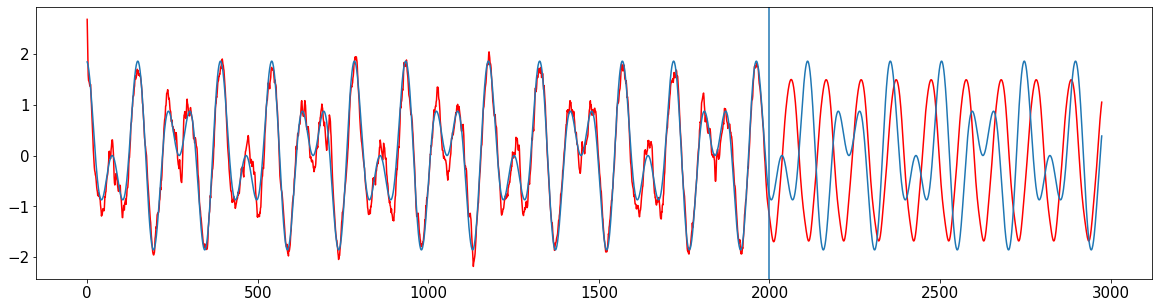

In [64]:
num_features = 25
num_samples = len(y)

test_size = 0
future_holdout = 1000

windowData = np.array(y[:num_features+1])
for i in range(1, num_samples - num_features):
    windowData = np.vstack((windowData, y[i:i+num_features+1]))

trainData = windowData[:-(test_size+future_holdout)]
testData = windowData[-(test_size+future_holdout):-future_holdout]

newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)

model = LSTM_multifeature(input_features=num_features, hidden_lstm_layers=[32, 32, 32])
criterion = nn.MSELoss()
optimiser = torch.optim.LBFGS(model.parameters(), lr=0.3)
# optimiser = torch.optim.Adam(model.parameters(), lr=0.3)


# Train the model
r = training_loop_multifeature(10, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY, num_batches=1, random_seed=100)

with torch.no_grad():
    future = 1000
    pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
    bigPred = pred[0].detach().numpy()

plt.plot(bigPred, color="r")
plt.plot(base_y[num_features:])
# plt.axvline(x=900)
plt.axvline(x=2000)
plt.show()

0.21362574
0.21362574


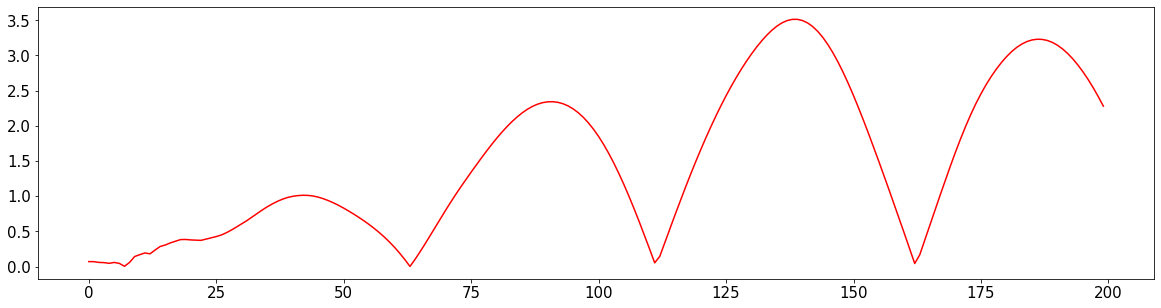

In [65]:
presentPred = bigPred[:-future_holdout]
futurePred = bigPred[-future_holdout:]

presentTrue = base_y[num_features:-future_holdout]
futureTrue = base_y[-future_holdout:]

error = np.sqrt(np.mean((presentPred - presentTrue)**2))
print(error)
print(RMSE(presentPred, presentTrue))

futureErrorWindow = 200
futureErrors = abs(futurePred[:futureErrorWindow] - futureTrue[:futureErrorWindow])
plt.plot(futureErrors, color="r")

results = {
    "Full Prediction" : bigPred,
    "RMSE" : error, 
    "FutureErrors" : futureErrors,
}

fourierResults["25Feature"] = results

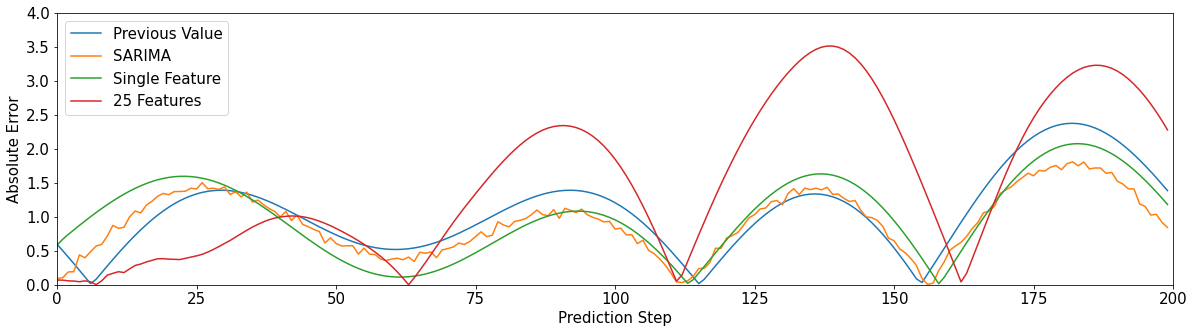

In [68]:
plt.rcParams.update({'font.size': 15})
plt.show()

plt.xlim(0, 200)
plt.ylim(0, 4)


plt.plot(fourierResults["PreviousValue"]["FutureErrors"], label="Previous Value")
plt.plot(fourierResults["SARIMA"]["FutureErrors"], label="SARIMA")
plt.plot(fourierResults["SingleFeature"]["FutureErrors"], label="Single Feature")
plt.plot(fourierResults["25Feature"]["FutureErrors"], label="25 Features")
plt.legend(loc='upper left',  prop={'size': 15})


plt.xlabel('Prediction Step')
plt.ylabel('Absolute Error')

plt.show()


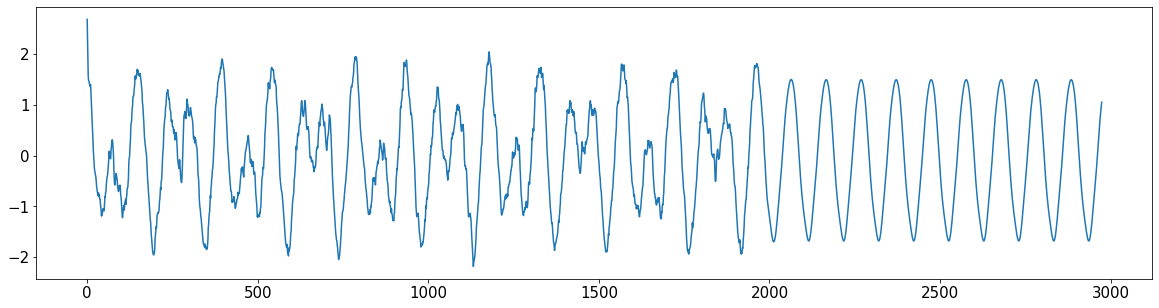

In [71]:
plt.plot(fourierResults["25Feature"]["Full Prediction"], label="25 Features")


## Testing LSTM Configurations

In [69]:
# num_features = 25
# num_samples = len(y)

# test_size = 0
# future_holdout = 1000

def train_neural_net(data, num_features, test_size, future_holdout, 
                     hidden_lstm_layers, criterion, optimiser, learning_rate, 
                     epochs, batches, min_batch_length, random_seed, print_results):
    
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    num_samples = len(data)

    windowData = np.array(data[:num_features+1])
    for i in range(1, num_samples - num_features):
        windowData = np.vstack((windowData, data[i:i+num_features+1]))

    trainData = windowData[:-(test_size+future_holdout)]
    testData = windowData[-(test_size+future_holdout):-future_holdout]

    newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
    newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

    newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
    newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)
    
    model = LSTM_multifeature(input_features=num_features, hidden_lstm_layers=hidden_lstm_layers)
    criterion = nn.MSELoss()
    optimiser = torch.optim.LBFGS(model.parameters(), lr=learning_rate)
    
    
    print(len(newTrainX), len(newTestX))
    # Train the model
    r = training_loop_multifeature(epochs, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY, 
                                   num_batches=batches, min_batch_length=min_batch_length, random_seed=random_seed)

    with torch.no_grad():
        future = 1000
        pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
        # print(pred[0])
        bigPred = pred[0].detach().numpy()
    
    presentPred = bigPred[:-future_holdout]
    futurePred = bigPred[-future_holdout:]

    presentTrue = base_y[num_features:-future_holdout]
    futureTrue = base_y[-future_holdout:]

    error = np.sqrt(np.mean((presentPred - presentTrue)**2))
    print("Error: ", error)
    print("RMSE: ", RMSE(presentPred, presentTrue))

    futureErrorWindow = 200
    futureErrors = abs(futurePred[:futureErrorWindow] - futureTrue[:futureErrorWindow])
    
    results = {
        "Full Prediction" : bigPred,
        "RMSE" : error, 
        "FutureErrors" : futureErrors,
    }
    
    modelString = """Features: {},
        Future Holdout: {},
        Hidden Layers: {},
        Learning Rate: {},
        Epochs: {},
        Batches: {}, 
        Min Batch Size: {},
        Random Seed: {}""".format(
            num_features, future_holdout, "[" + ", ".join([str(x) for x in hidden_lstm_layers]) + "]", 
            learning_rate, epochs, batches, min_batch_length, random_seed)

    results = {
        "Desc" : modelString, 
        "Model" : model, 
        "Full Pred" : bigPred, 
        "Future Errors": futureErrors,
    }
    
    if print_results:
        print(modelString)
        
        plt.plot(bigPred, color="r")
        plt.plot(base_y[num_features:])
        # plt.axvline(x=900)
        plt.axvline(x=len(data) - future_holdout)
        plt.show()
        
        print("Error: ", error)
        print("RMSE: ", RMSE(presentPred, presentTrue))
        
        plt.plot(futureErrors, color="r")
        plt.show()
    
    return results

Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.5723, grad_fn=<MseLossBackward0>)
Error:  0.65118194
RMSE:  0.65118194
Features: 25,
        Future Holdout: 1000,
        Hidden Layers: [32],
        Learning Rate: 0.03,
        Epochs: 1,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


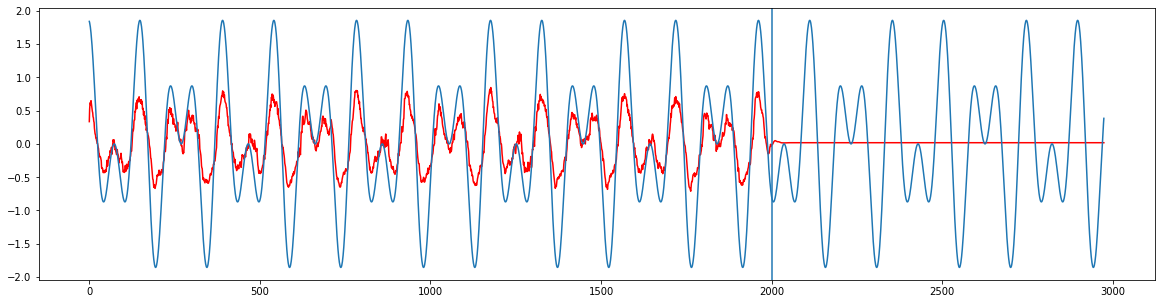

Error:  0.65118194
RMSE:  0.65118194


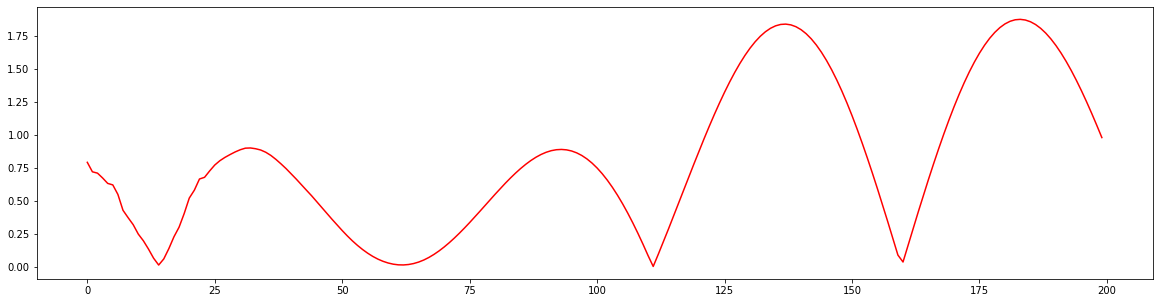

In [28]:
results = train_neural_net(data=y, num_features=25, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers= [32], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.03, 
                 epochs=1, batches=1, min_batch_length=100, random_seed=100, print_results=True)

1975 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.2448, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.1835, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1766, grad_fn=<MseLossBackward0>)
Error:  0.21862742
RMSE:  0.21862742
Features: 25,
        Future Holdout: 1000,
        Hidden Layers: [32],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


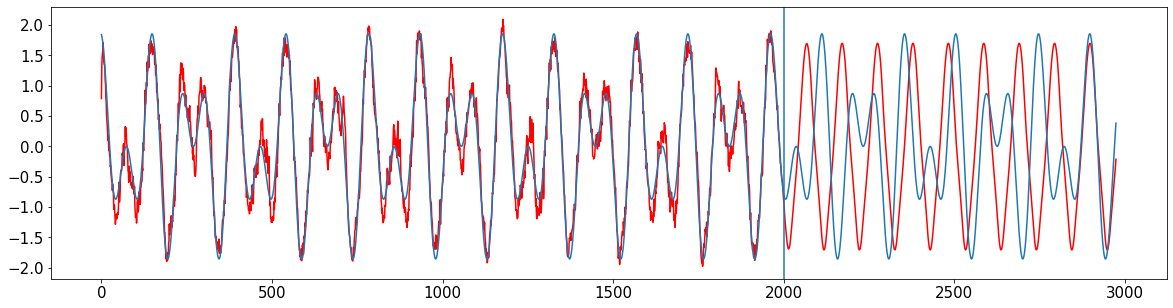

Error:  0.21862742
RMSE:  0.21862742


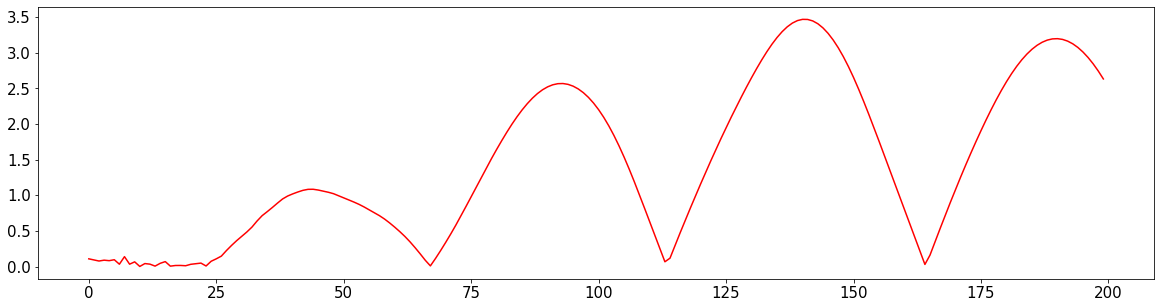

1975 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.2493, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.1890, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1796, grad_fn=<MseLossBackward0>)
Error:  0.22424106
RMSE:  0.22424106
Features: 25,
        Future Holdout: 1000,
        Hidden Layers: [32, 32],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


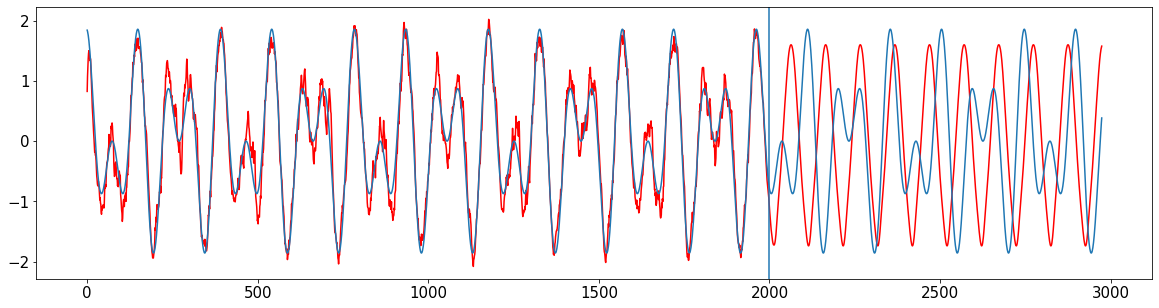

Error:  0.22424106
RMSE:  0.22424106


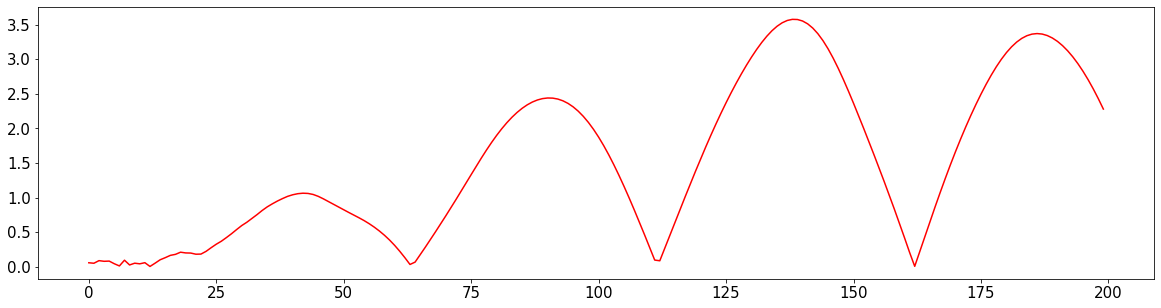

1975 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.9523, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.3202, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.2302, grad_fn=<MseLossBackward0>)
Error:  0.31526834
RMSE:  0.31526834
Features: 25,
        Future Holdout: 1000,
        Hidden Layers: [32, 32, 32],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


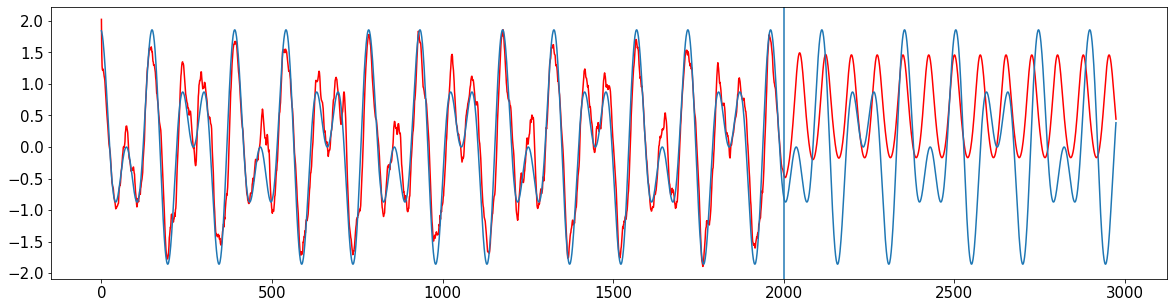

Error:  0.31526834
RMSE:  0.31526834


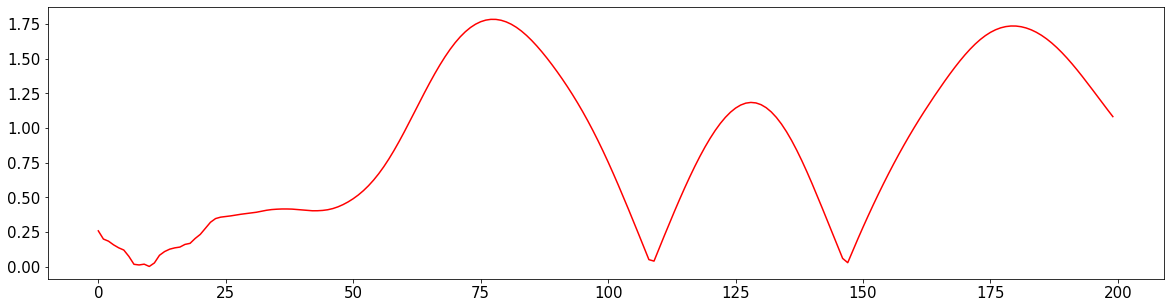

1975 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(1.1284, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(1.0838, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.7327, grad_fn=<MseLossBackward0>)
Error:  0.7602332
RMSE:  0.7602332
Features: 25,
        Future Holdout: 1000,
        Hidden Layers: [32, 32, 32, 32],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


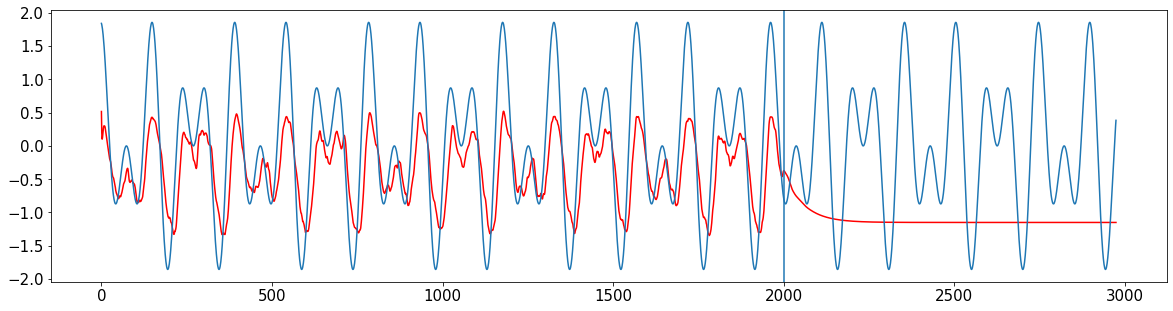

Error:  0.7602332
RMSE:  0.7602332


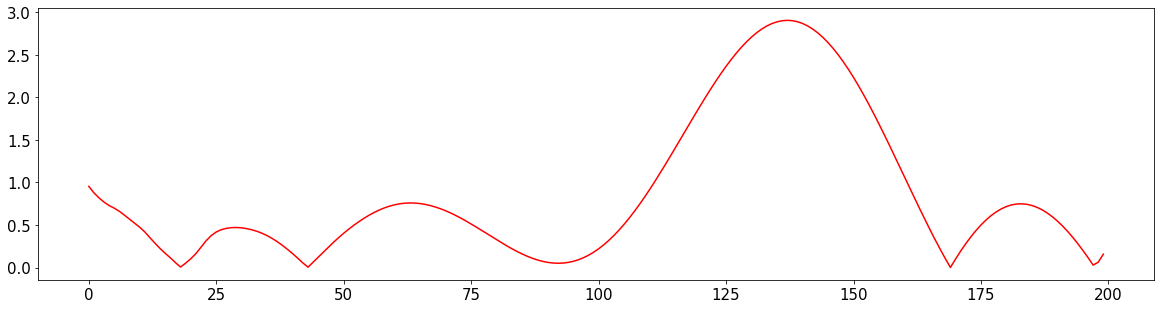

1975 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.2157, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.1684, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1627, grad_fn=<MseLossBackward0>)
Error:  0.18888678
RMSE:  0.18888678
Features: 25,
        Future Holdout: 1000,
        Hidden Layers: [64],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


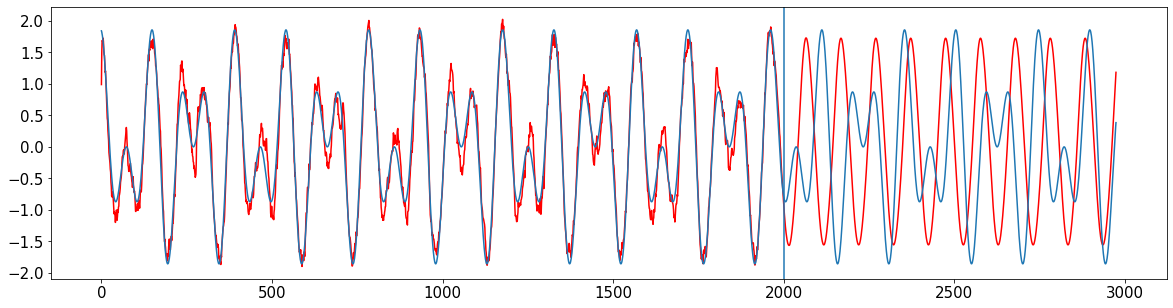

Error:  0.18888678
RMSE:  0.18888678


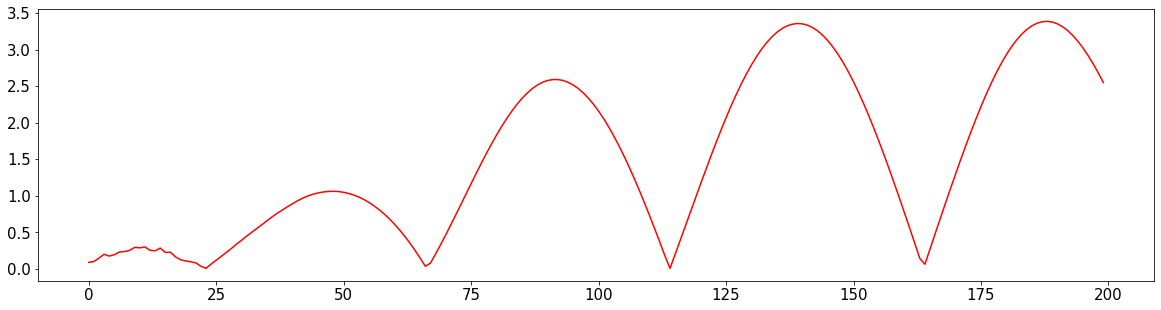

1975 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.2204, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.1651, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1606, grad_fn=<MseLossBackward0>)
Error:  0.1853123
RMSE:  0.1853123
Features: 25,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


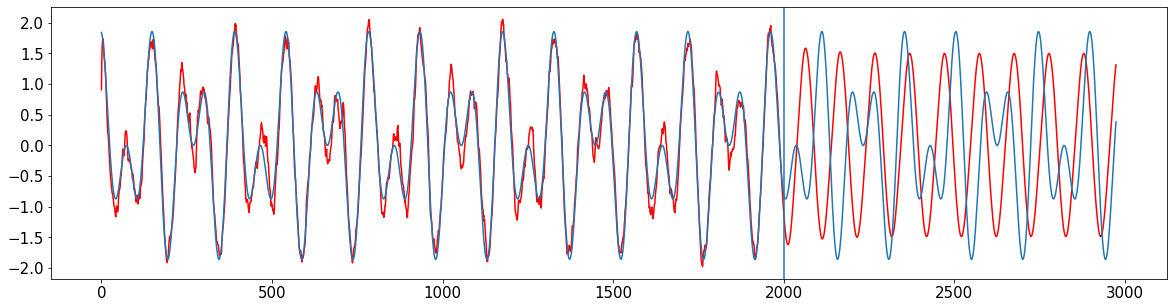

Error:  0.1853123
RMSE:  0.1853123


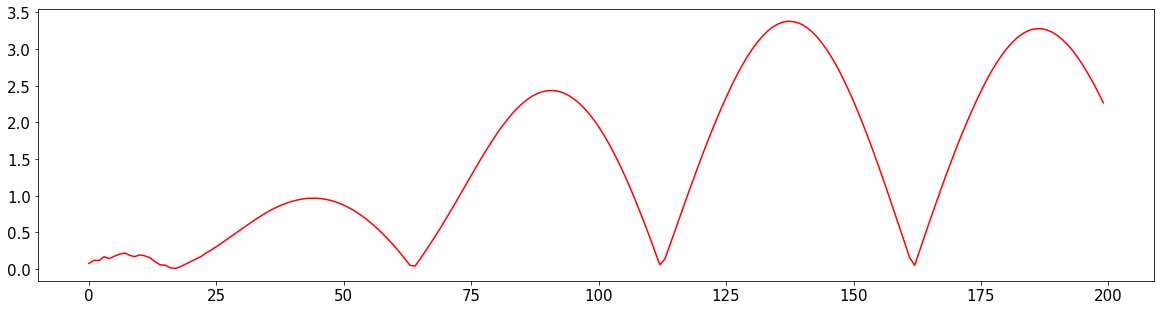

1975 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.2152, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.1640, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1598, grad_fn=<MseLossBackward0>)
Error:  0.18104677
RMSE:  0.18104677
Features: 25,
        Future Holdout: 1000,
        Hidden Layers: [256],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


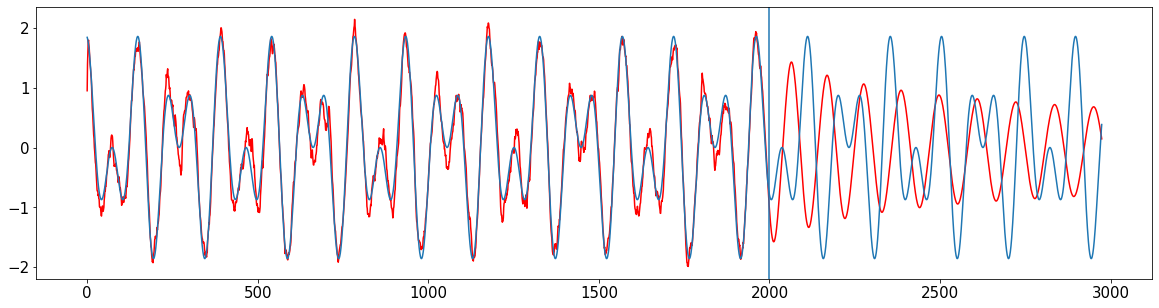

Error:  0.18104677
RMSE:  0.18104677


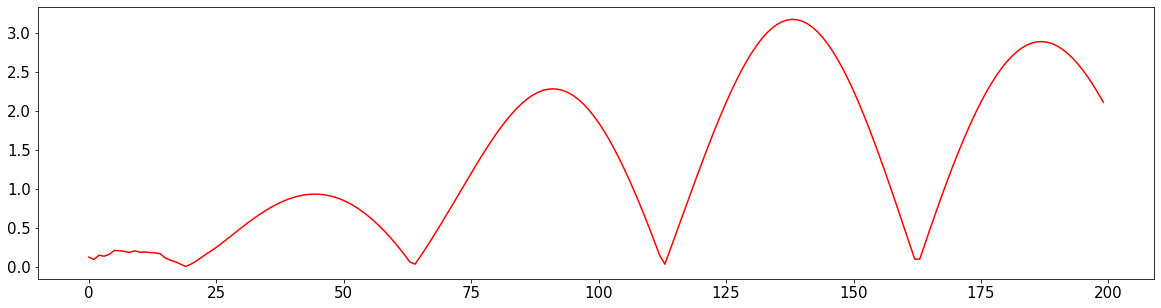

1975 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.2728, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.2028, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1910, grad_fn=<MseLossBackward0>)
Error:  0.25708765
RMSE:  0.25708765
Features: 25,
        Future Holdout: 1000,
        Hidden Layers: [128, 64, 32],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


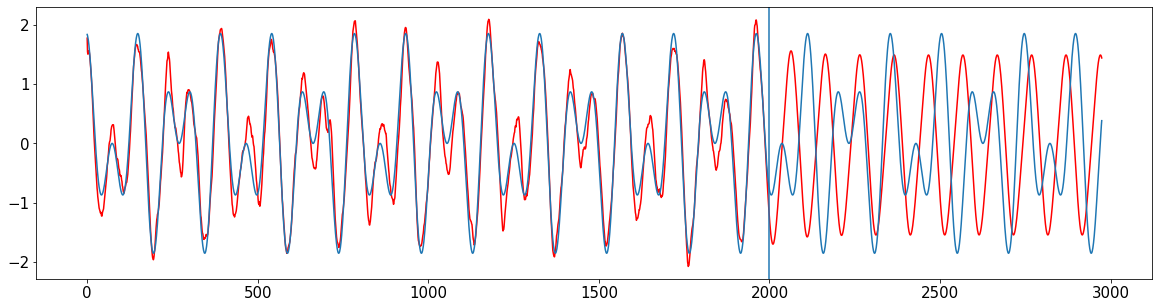

Error:  0.25708765
RMSE:  0.25708765


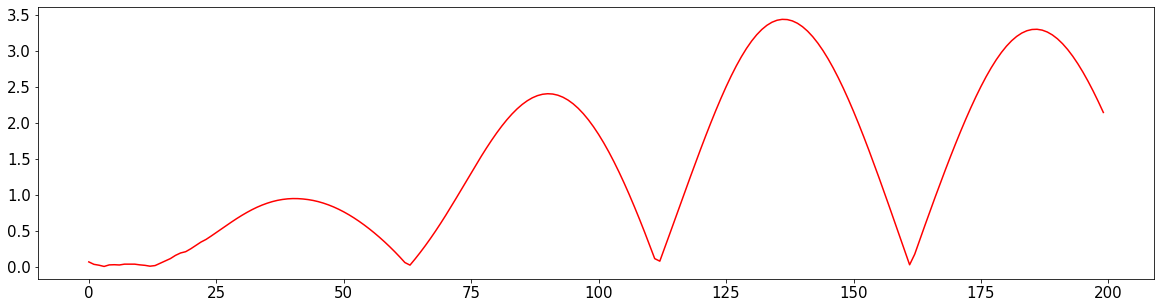

In [70]:
hidden_layers_tests = [
    [32],
    [32, 32],
    [32, 32, 32],
    [32, 32, 32, 32],
    [64],
    [128],
    [256],
    [128, 64, 32],
]


hiddenLayerResults = []
for h in hidden_layers_tests:
    hiddenLayerResults.append(train_neural_net(data=y, num_features=25, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=h, criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.08, 
                 epochs=3, batches=1, min_batch_length=100, random_seed=100, print_results=True))

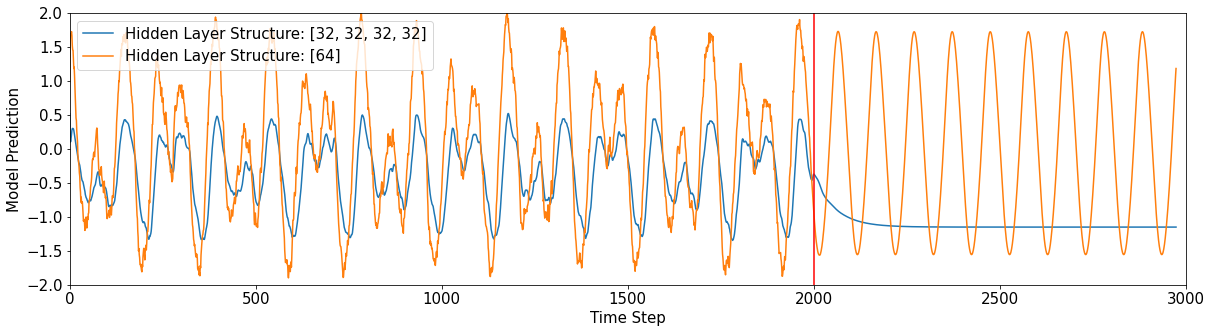

In [93]:
plt.rcParams.update({'font.size': 15})
plt.show()

plt.xlim(0, 3000)
plt.ylim(-2, 2)

# for r, l in zip(hiddenLayerResults, hidden_layers_tests):
#     plt.plot(r["Full Pred"], label="[" + ", ".join([str(c) for c in l]) + "]")

# plt.plot(fourierResults["PreviousValue"]["FutureErrors"], label="Previous Value")
# plt.plot(fourierResults["SARIMA"]["FutureErrors"], label="SARIMA")
# plt.plot(fourierResults["SingleFeature"]["FutureErrors"], label="Single Feature")
# plt.plot(fourierResults["25Feature"]["FutureErrors"], label="25 Features")

# plt.plot(base_y[25:], label="True Pattern")
plt.plot(hiddenLayerResults[3]["Full Pred"], label="Hidden Layer Structure: [" + ", ".join([str(c) for c in hidden_layers_tests[3]]) + "]")
plt.plot(hiddenLayerResults[4]["Full Pred"], label="Hidden Layer Structure: [" + ", ".join([str(c) for c in hidden_layers_tests[4]]) + "]")

# plt.plot(r["Full Pred"], label="[" + ", ".join([str(c) for c in l]) + "]")


plt.legend(loc='upper left',  prop={'size': 15})
plt.axvline(x=len(y) - 1000, color="r")

plt.xlabel('Time Step')
plt.ylabel('Model Prediction')

plt.show()


In [94]:
# train_neural_net(data=y, num_features=25, test_size=0, future_holdout=1000, 
#                  hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.03, 
#                  epochs=3, batches=1, min_batch_length=100, random_seed=100, print_results=True)

In [95]:
# train_neural_net(data=y, num_features=25, test_size=0, future_holdout=1000, 
#                  hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.03, 
#                  epochs=10, batches=1, min_batch_length=100, random_seed=100, print_results=True)

In [96]:
# a = train_neural_net(data=y, num_features=25, test_size=0, future_holdout=1000, 
#                  hidden_lstm_layers=[512], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.03, 
#                  epochs=3, batches=1, min_batch_length=100, random_seed=100, print_results=True)

In [97]:
# a = train_neural_net(data=y, num_features=100, test_size=0, future_holdout=1000, 
#                  hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.08, 
#                  epochs=3, batches=1, min_batch_length=100, random_seed=100, print_results=True)

1999 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.2281, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.1873, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1858, grad_fn=<MseLossBackward0>)
Error:  0.24416173
RMSE:  0.24416173
Features: 1,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


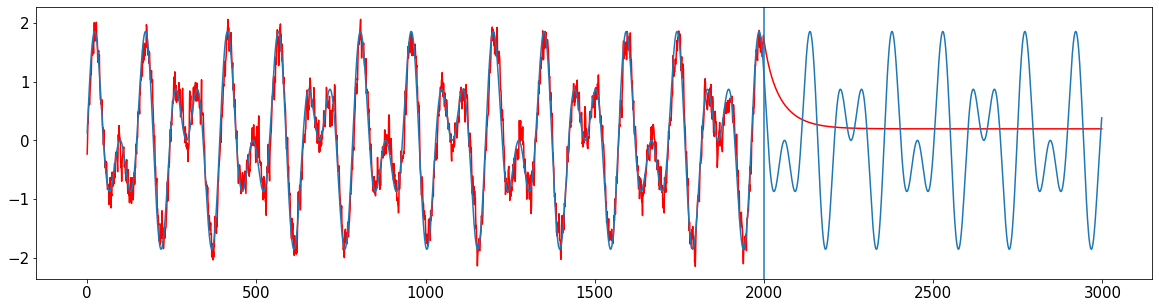

Error:  0.24416173
RMSE:  0.24416173


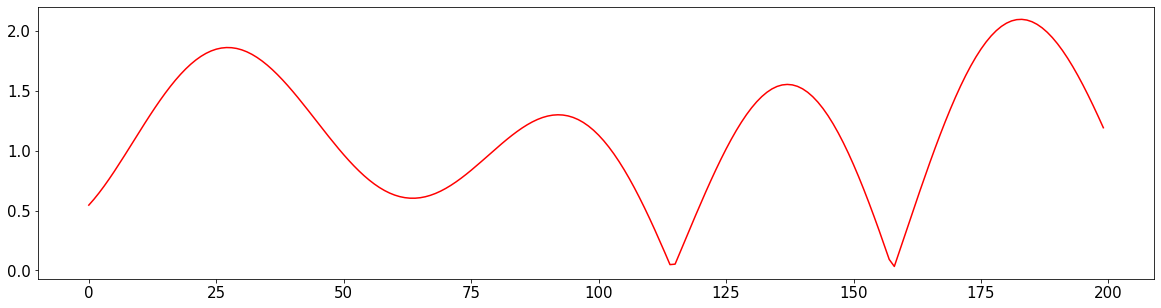

1990 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.2518, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.1760, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1707, grad_fn=<MseLossBackward0>)
Error:  0.20818053
RMSE:  0.20818053
Features: 10,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


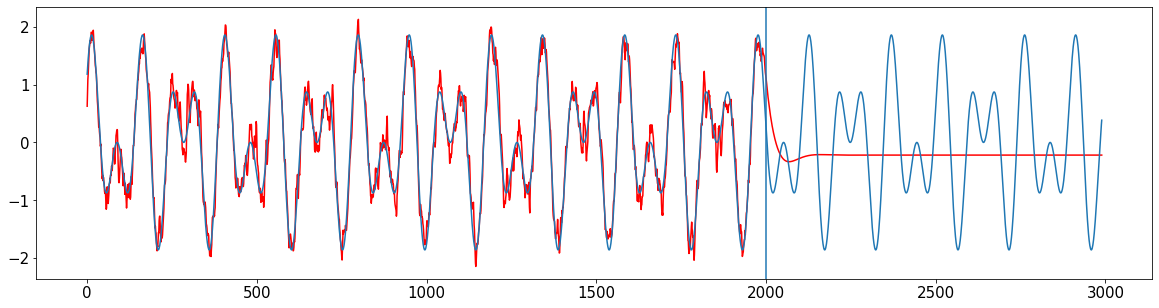

Error:  0.20818053
RMSE:  0.20818053


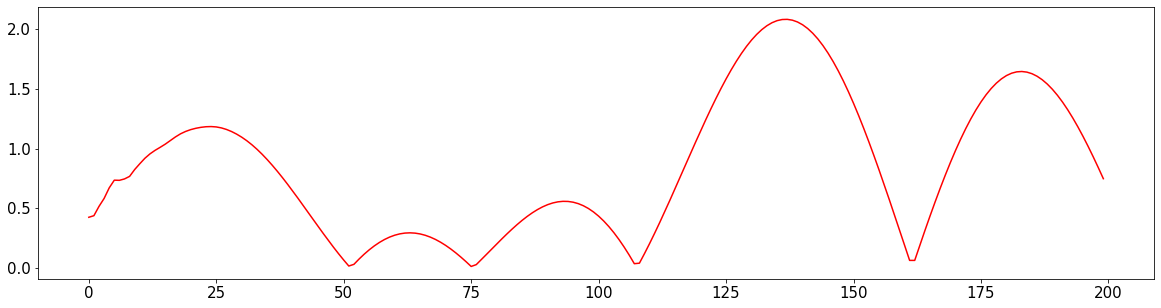

1975 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.2204, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.1651, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1606, grad_fn=<MseLossBackward0>)
Error:  0.1853123
RMSE:  0.1853123
Features: 25,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


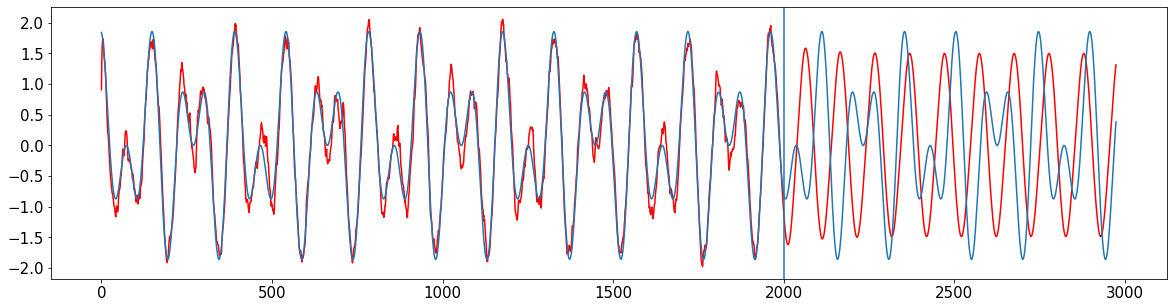

Error:  0.1853123
RMSE:  0.1853123


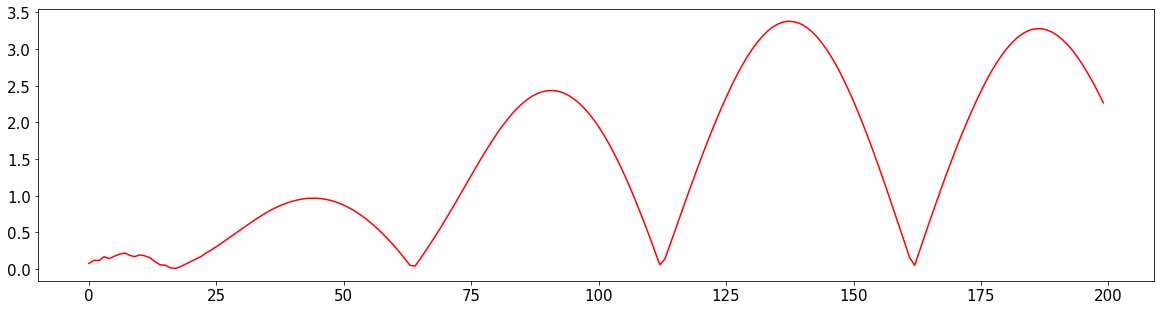

1950 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.2285, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.1667, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1573, grad_fn=<MseLossBackward0>)
Error:  0.17555147
RMSE:  0.17555147
Features: 50,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


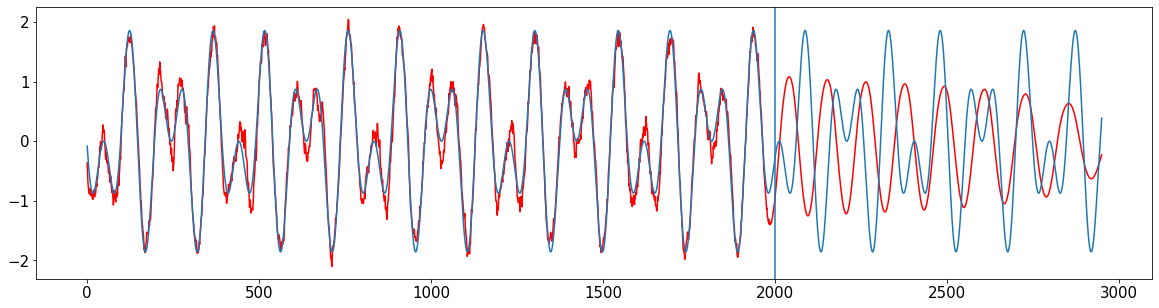

Error:  0.17555147
RMSE:  0.17555147


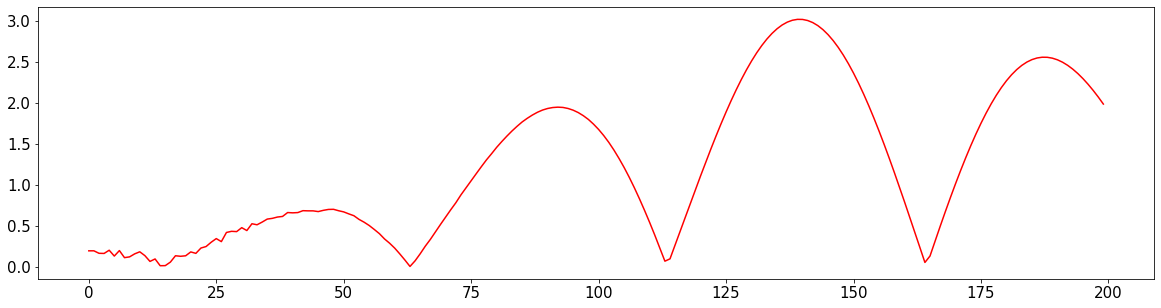

1900 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.1897, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.1457, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1397, grad_fn=<MseLossBackward0>)
Error:  0.124917634
RMSE:  0.124917634
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 100,
        Random Seed: 100


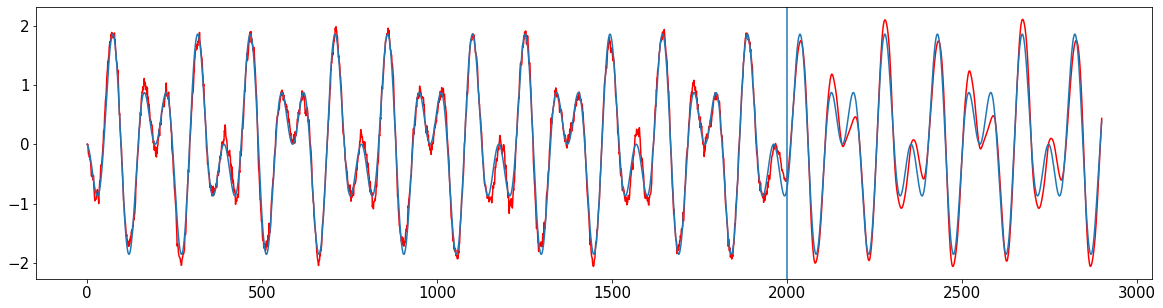

Error:  0.124917634
RMSE:  0.124917634


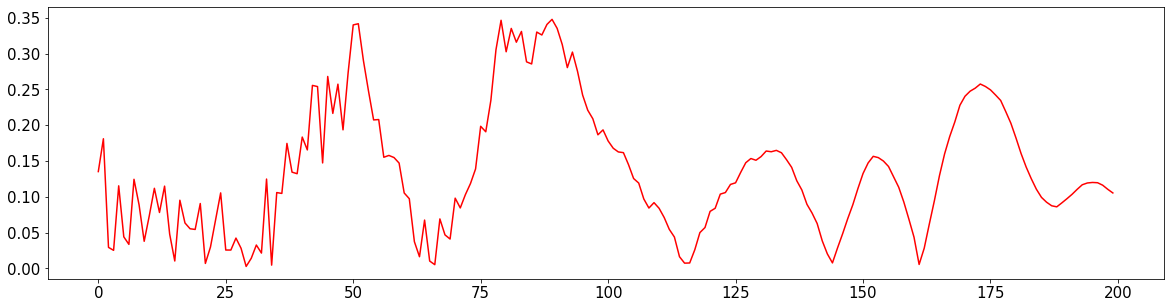

In [92]:
featureSizeModels = []
featureSizeTests = [1, 10, 25, 50, 100]

for f in featureSizeTests:
    featureSizeModels.append(train_neural_net(data=y, num_features=f, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.08, 
                 epochs=3, batches=1, min_batch_length=100, random_seed=100, print_results=True))

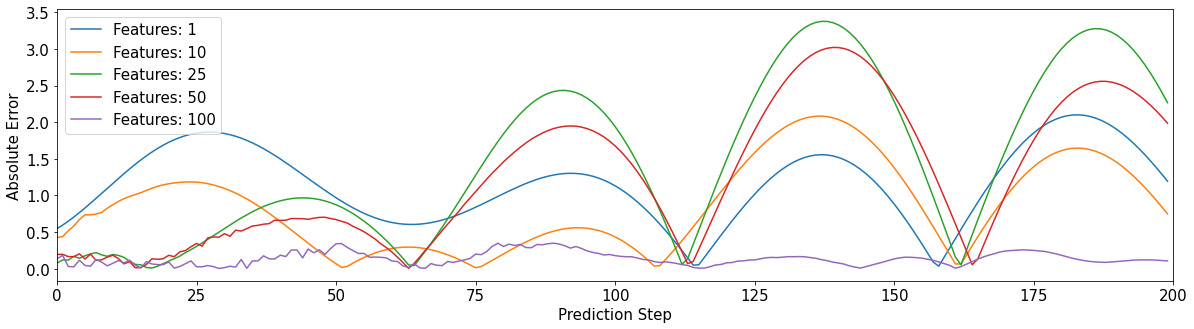

In [98]:
for m, s in zip(featureSizeModels, featureSizeTests):
    plt.plot(m["Future Errors"], label="Features: {}".format(str(s)))
    
plt.legend(loc='upper left')
plt.xlim(0, 200)
plt.xlabel('Prediction Step')
plt.ylabel('Absolute Error')
plt.show()

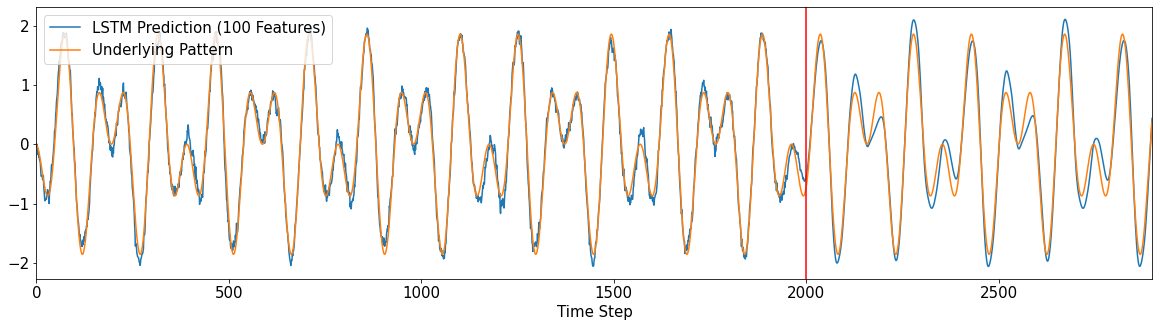

In [113]:
plt.rcParams.update({'font.size': 15})
plt.show()

plt.xlim(0, 2900)
# plt.ylim(0, 4)

plt.plot(featureSizeModels[-1]["Full Pred"], label="LSTM Prediction (100 Features)")
plt.plot(base_y[100:], label="Underlying Pattern")
plt.legend(loc='upper left',  prop={'size': 15})
plt.axvline(x=len(y) - 1000, color="r")


plt.xlabel('Time Step')
# plt.ylabel('Absolute Error')

plt.show()


1900 0
Epoch:  0 , Batch Indicies:  None
Loss:  tensor(0.1897, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  None
Loss:  tensor(0.1457, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  None
Loss:  tensor(0.1397, grad_fn=<MseLossBackward0>)
Error:  0.124917634
RMSE:  0.124917634
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 1000,
        Random Seed: 100


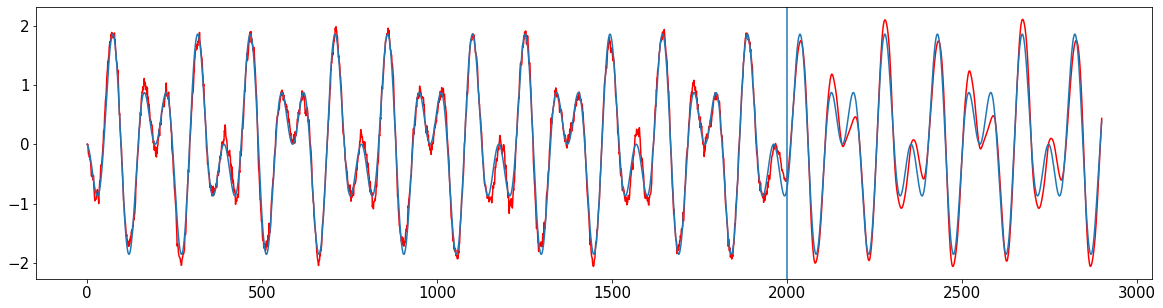

Error:  0.124917634
RMSE:  0.124917634


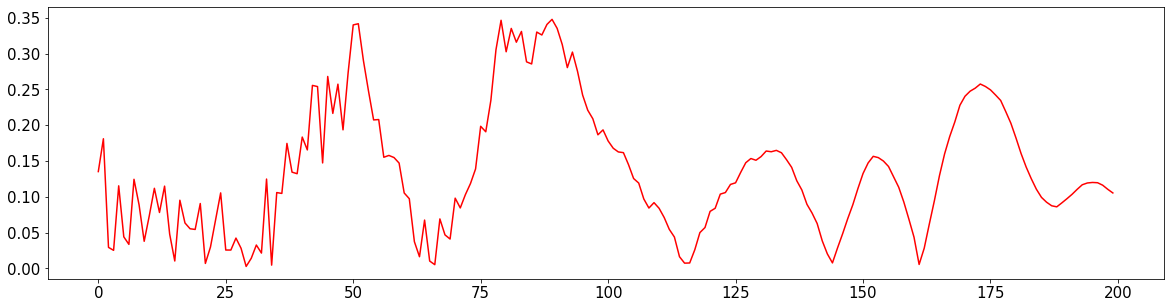

1900 0
Epoch:  0 , Batch Indicies:  [0, 941, 1900]
Loss:  tensor(0.1959, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1386, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 804, 1900]
Loss:  tensor(0.1459, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1310, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 887, 1900]
Loss:  tensor(0.1254, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1371, grad_fn=<MseLossBackward0>)
Error:  0.12425587
RMSE:  0.12425587
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 2, 
        Min Batch Size: 800,
        Random Seed: 100


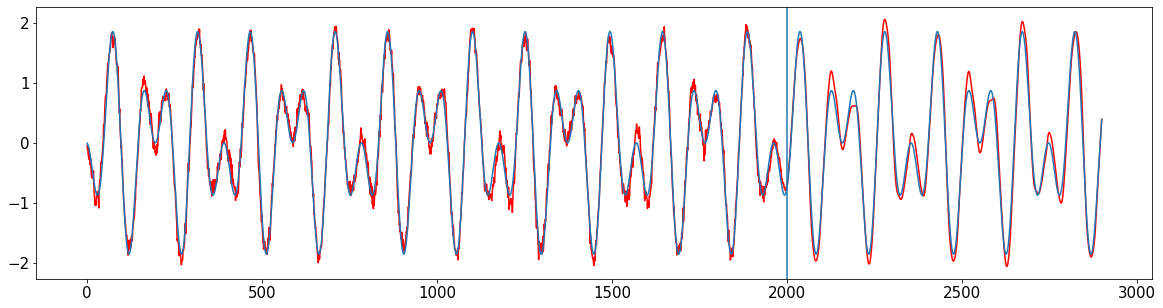

Error:  0.12425587
RMSE:  0.12425587


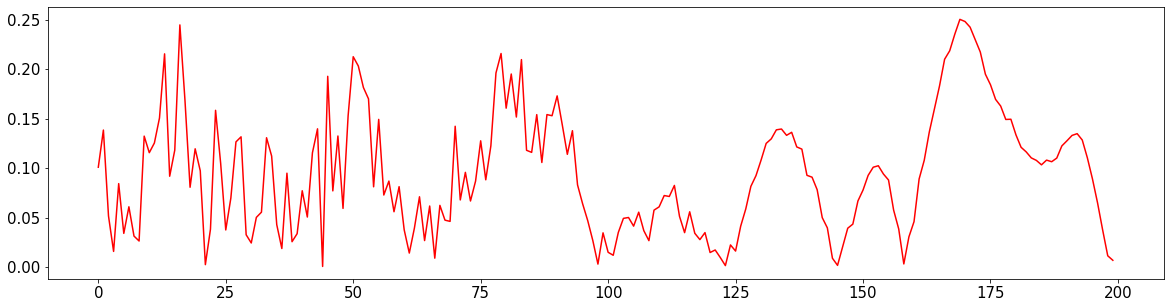

1900 0
Epoch:  0 , Batch Indicies:  [0, 757, 1282, 1900]
Loss:  tensor(0.1822, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1530, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1345, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 564, 1137, 1900]
Loss:  tensor(0.1317, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1417, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1238, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 693, 1209, 1900]
Loss:  tensor(0.1302, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1235, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1316, grad_fn=<MseLossBackward0>)
Error:  0.13542008
RMSE:  0.13542008
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 3, 
        Min Batch Size: 500,
        Random Seed: 100


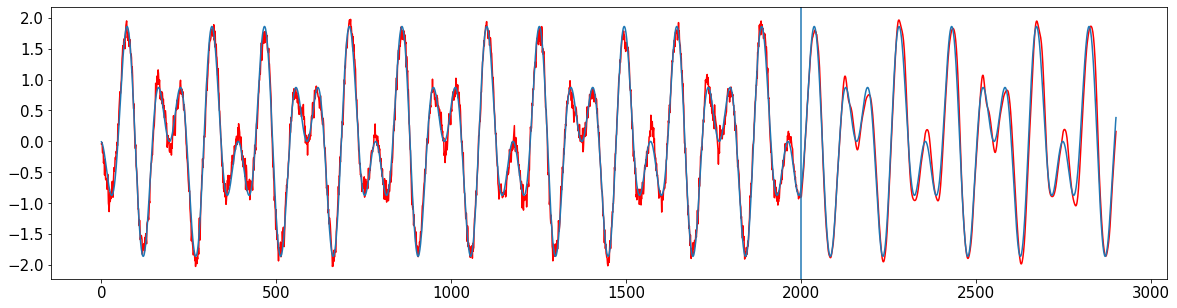

Error:  0.13542008
RMSE:  0.13542008


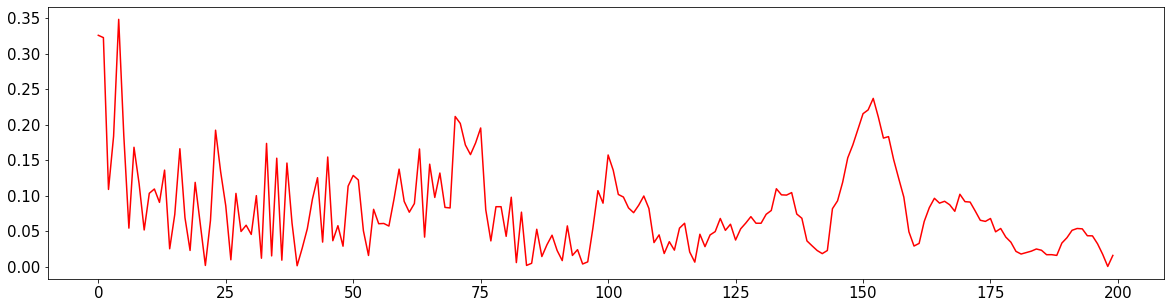

1900 0
Epoch:  0 , Batch Indicies:  [0, 302, 810, 1234, 1900]
Loss:  tensor(0.1842, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1419, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1440, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1434, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 485, 917, 1363, 1900]
Loss:  tensor(0.1186, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1301, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1369, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1266, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 654, 1039, 1440, 1900]
Loss:  tensor(0.1268, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1190, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1363, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1281, grad_fn=<MseLossBackward0>)
Error:  0.1633915
RMSE:  0.1633915
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 4, 
        Min Batch Size: 300,
        Random Seed

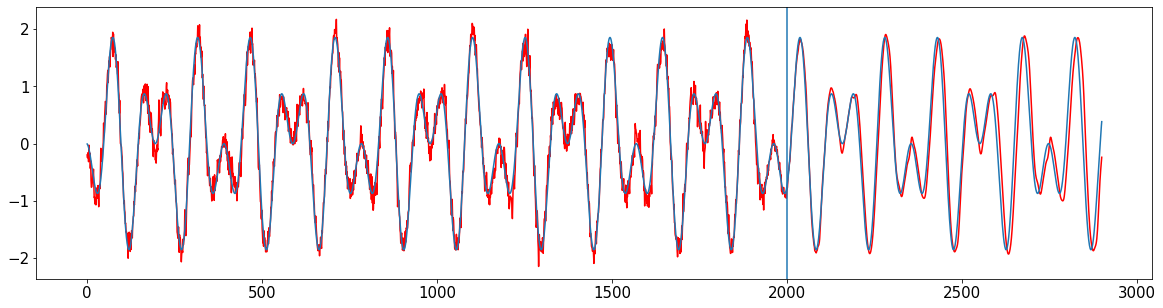

Error:  0.1633915
RMSE:  0.1633915


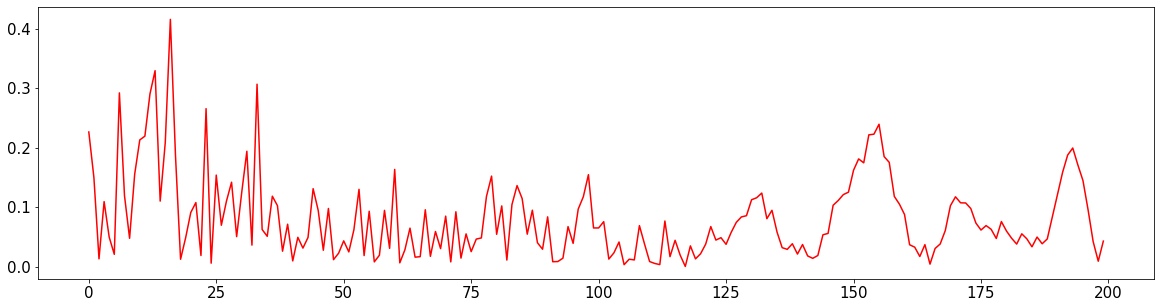

1900 0
Epoch:  0 , Batch Indicies:  [0, 297, 514, 855, 1692, 1900]
Loss:  tensor(0.1783, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1375, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1400, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1394, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1365, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 278, 936, 1296, 1528, 1900]
Loss:  tensor(0.1176, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1339, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1259, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1335, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1258, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 348, 733, 1158, 1508, 1900]
Loss:  tensor(0.1108, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1338, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1206, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1263, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1244, grad_fn=<MseLossBackward0>)
Error:  0.15068002
RMSE:  0.15068002
Features: 100,
        F

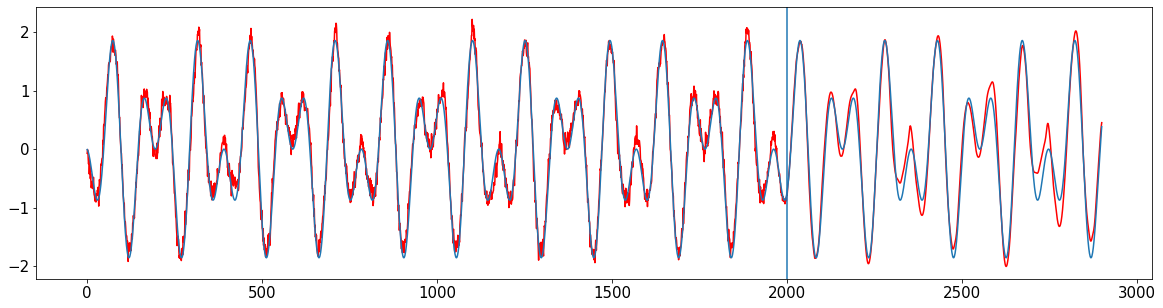

Error:  0.15068002
RMSE:  0.15068002


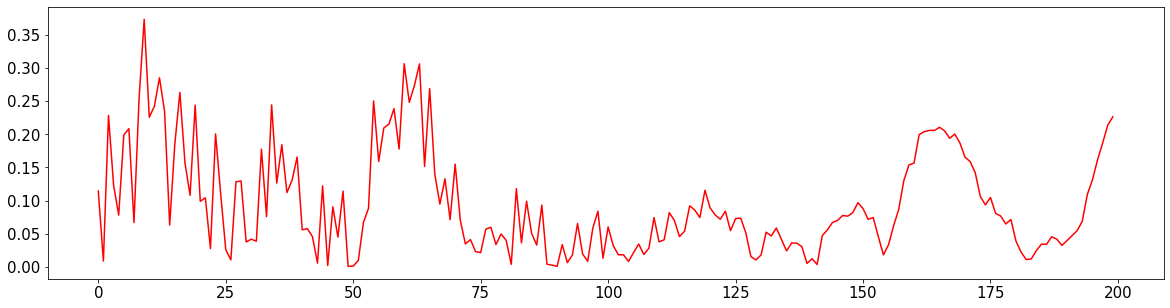

In [116]:
batchSizeModels = []
batchSizeTests = [(1, 1000), (2, 800), (3, 500), (4, 300), (5, 200)]

for b in batchSizeTests:
    batchSizeModels.append(train_neural_net(data=y, num_features=100, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.08, 
                 epochs=3, batches=b[0], min_batch_length=b[1], random_seed=100, print_results=True))

[(1, 0.37010267), (2, 0.30792928), (3, 0.28426453), (4, 0.2840952), (5, 0.30822405)]


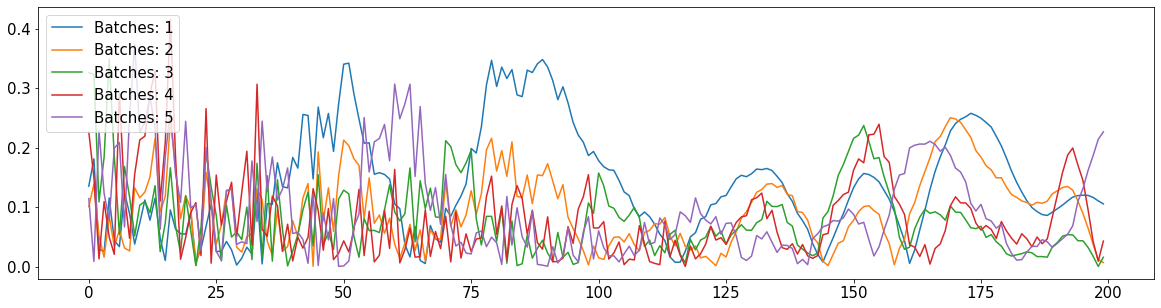

In [117]:
batchErrors = []

for m, s in zip(batchSizeModels, batchSizeTests):
    plt.plot(m["Future Errors"], label="Batches: {}".format(str(s[0])))
    error = np.sqrt(np.mean(m["Future Errors"]))
    batchErrors.append((s[0], error))
    
print(batchErrors)
plt.legend(loc='upper left')
plt.show()

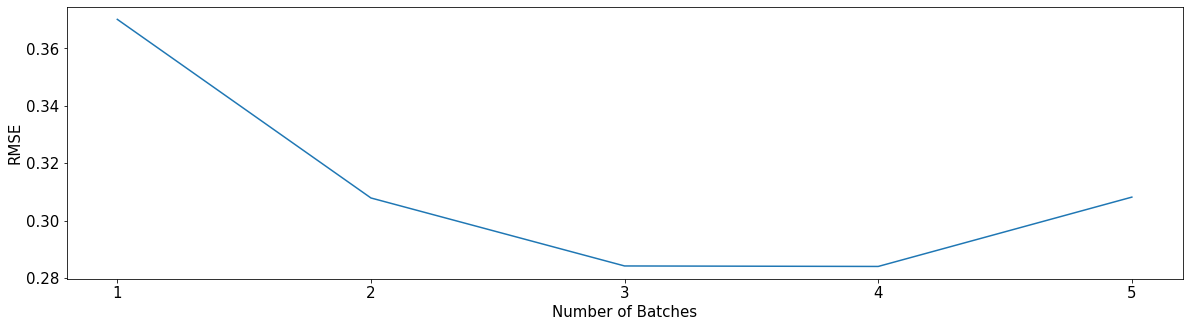

In [119]:
plt.plot([x[0] for x in batchErrors], [x[1] for x in batchErrors])
plt.xticks([1, 2, 3, 4, 5])
# plt.legend(loc='upper left')
# plt.xlim(0, 5)
plt.xlabel('Number of Batches')
plt.ylabel('RMSE')
plt.show()

1900 0
Epoch:  0 , Batch Indicies:  [0, 757, 1282, 1900]
Loss:  tensor(0.8981, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.8163, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.6820, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 564, 1137, 1900]
Loss:  tensor(0.6549, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.6408, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.5513, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 693, 1209, 1900]
Loss:  tensor(0.5217, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.4574, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.4538, grad_fn=<MseLossBackward0>)
Error:  0.5625914
RMSE:  0.5625914
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.003,
        Epochs: 3,
        Batches: 3, 
        Min Batch Size: 500,
        Random Seed: 100


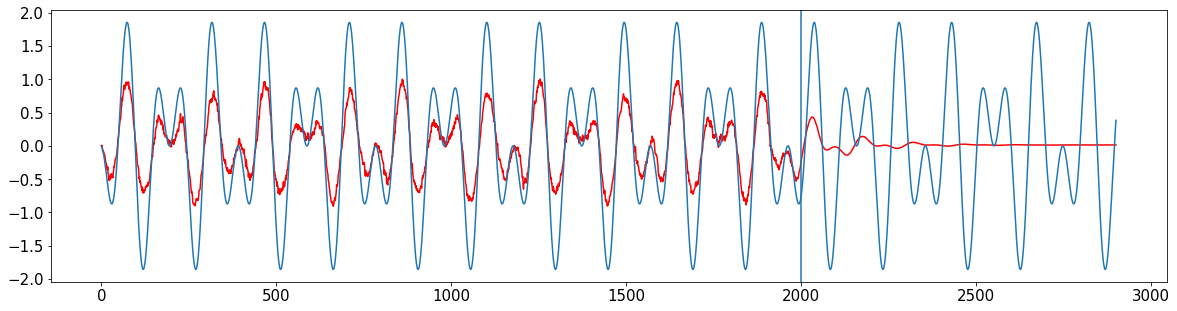

Error:  0.5625914
RMSE:  0.5625914


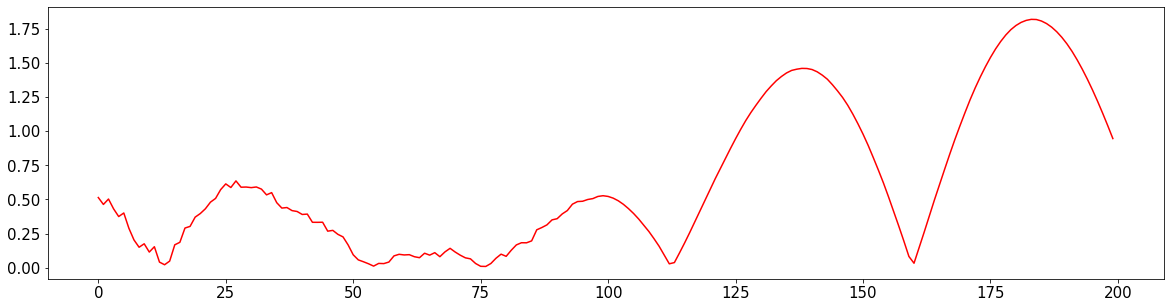

1900 0
Epoch:  0 , Batch Indicies:  [0, 757, 1282, 1900]
Loss:  tensor(0.7296, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.5448, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.3818, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 564, 1137, 1900]
Loss:  tensor(0.3149, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.2839, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.2164, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 693, 1209, 1900]
Loss:  tensor(0.2042, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1707, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1621, grad_fn=<MseLossBackward0>)
Error:  0.20103045
RMSE:  0.20103045
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.01,
        Epochs: 3,
        Batches: 3, 
        Min Batch Size: 500,
        Random Seed: 100


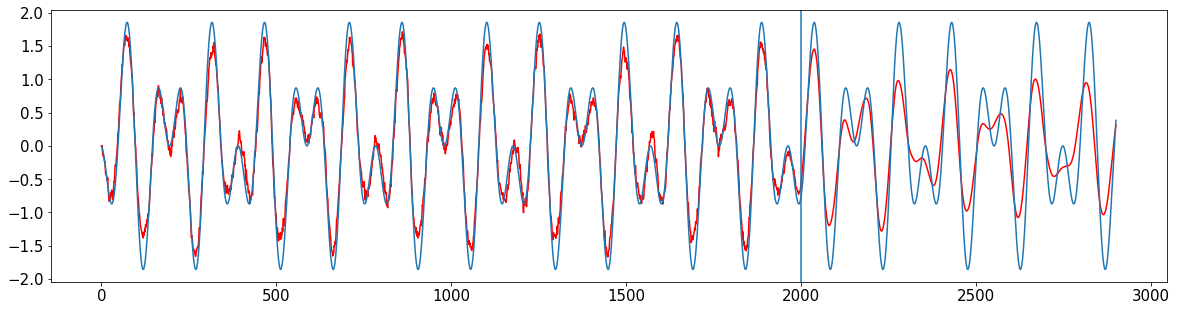

Error:  0.20103045
RMSE:  0.20103045


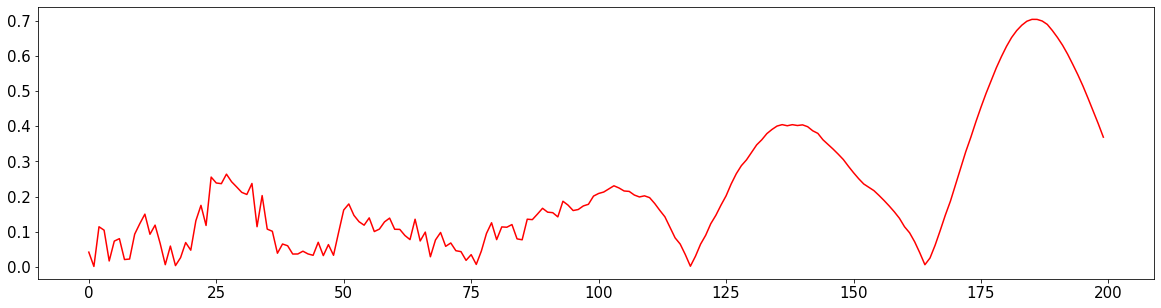

1900 0
Epoch:  0 , Batch Indicies:  [0, 757, 1282, 1900]
Loss:  tensor(0.4246, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.2372, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1620, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 564, 1137, 1900]
Loss:  tensor(0.1374, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1568, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1280, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 693, 1209, 1900]
Loss:  tensor(0.1420, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1238, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1306, grad_fn=<MseLossBackward0>)
Error:  0.12042772
RMSE:  0.12042772
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.03,
        Epochs: 3,
        Batches: 3, 
        Min Batch Size: 500,
        Random Seed: 100


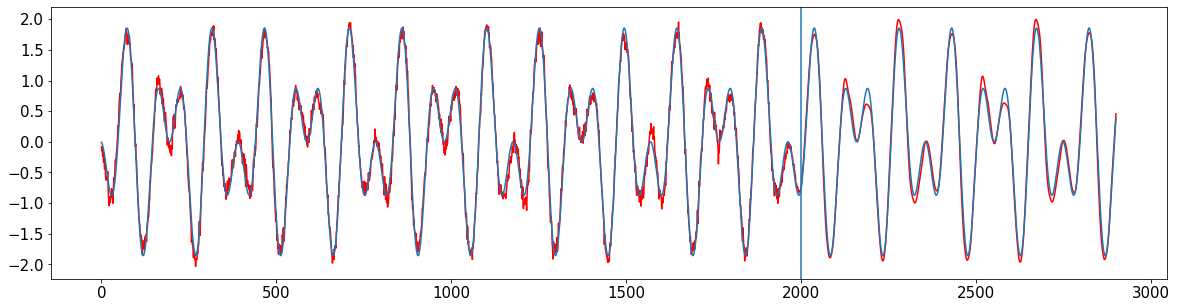

Error:  0.12042772
RMSE:  0.12042772


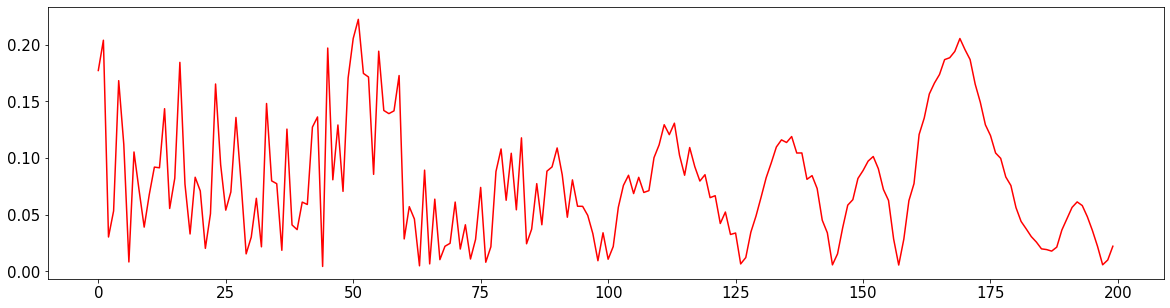

1900 0
Epoch:  0 , Batch Indicies:  [0, 757, 1282, 1900]
Loss:  tensor(0.2751, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1700, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1402, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 564, 1137, 1900]
Loss:  tensor(0.1340, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1500, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1270, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 693, 1209, 1900]
Loss:  tensor(0.1364, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1254, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1299, grad_fn=<MseLossBackward0>)
Error:  0.12530531
RMSE:  0.12530531
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.05,
        Epochs: 3,
        Batches: 3, 
        Min Batch Size: 500,
        Random Seed: 100


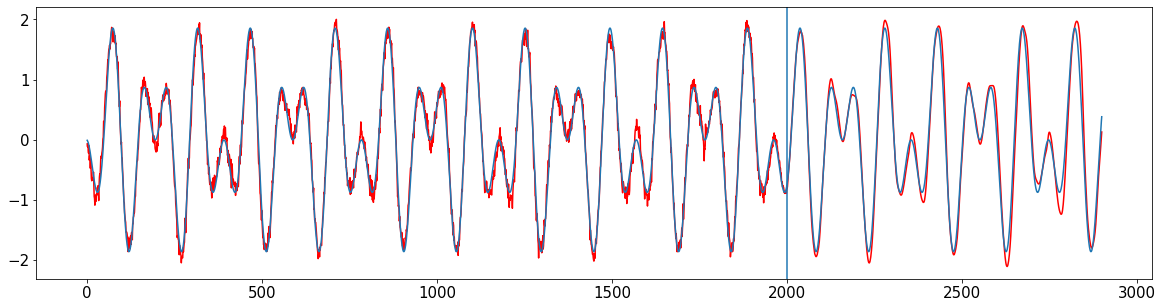

Error:  0.12530531
RMSE:  0.12530531


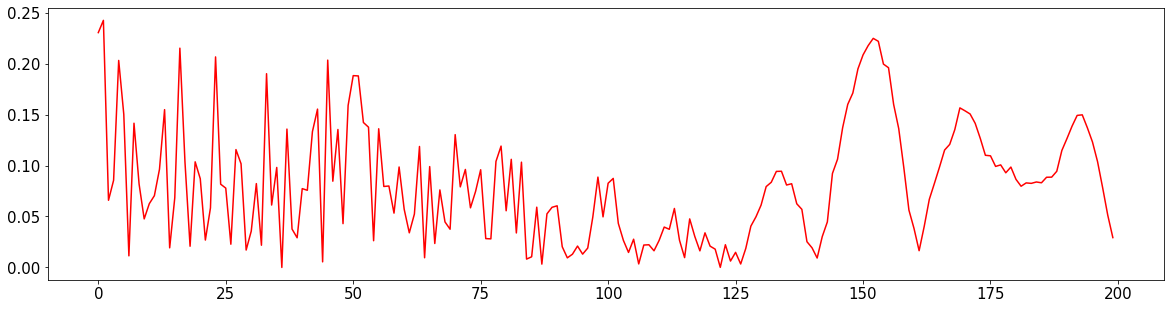

1900 0
Epoch:  0 , Batch Indicies:  [0, 757, 1282, 1900]
Loss:  tensor(0.1822, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1530, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1345, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 564, 1137, 1900]
Loss:  tensor(0.1317, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1417, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1238, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 693, 1209, 1900]
Loss:  tensor(0.1302, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1235, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1316, grad_fn=<MseLossBackward0>)
Error:  0.13542008
RMSE:  0.13542008
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 3, 
        Min Batch Size: 500,
        Random Seed: 100


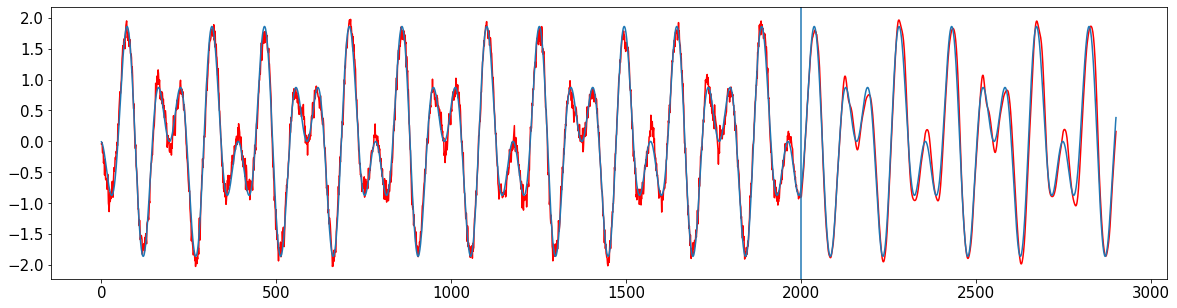

Error:  0.13542008
RMSE:  0.13542008


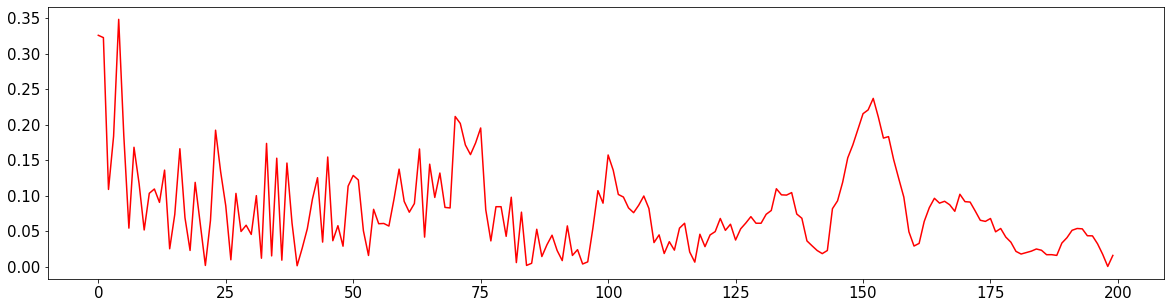

1900 0
Epoch:  0 , Batch Indicies:  [0, 757, 1282, 1900]
Loss:  tensor(0.1402, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1418, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1336, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 564, 1137, 1900]
Loss:  tensor(0.1290, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1329, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1190, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 693, 1209, 1900]
Loss:  tensor(0.1256, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1152, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1187, grad_fn=<MseLossBackward0>)
Error:  0.15511546
RMSE:  0.15511546
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.15,
        Epochs: 3,
        Batches: 3, 
        Min Batch Size: 500,
        Random Seed: 100


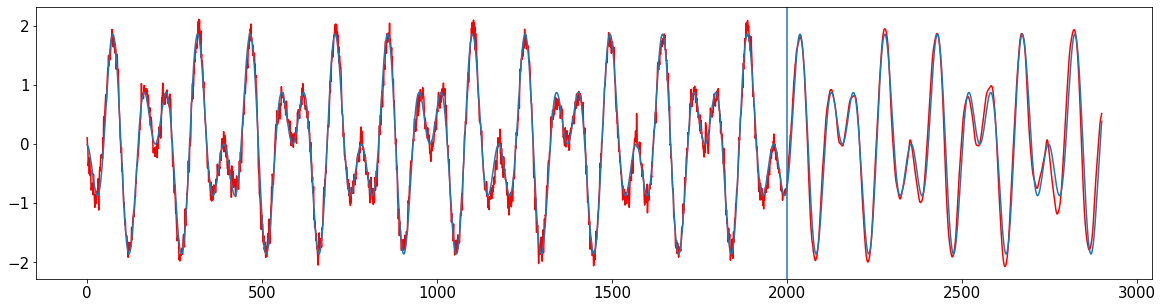

Error:  0.15511546
RMSE:  0.15511546


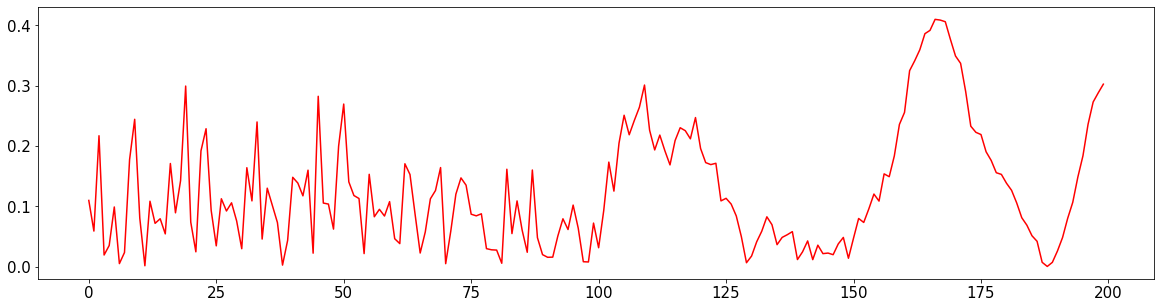

1900 0
Epoch:  0 , Batch Indicies:  [0, 757, 1282, 1900]
Loss:  tensor(0.1314, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1279, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1165, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 564, 1137, 1900]
Loss:  tensor(0.1174, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1181, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1070, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 693, 1209, 1900]
Loss:  tensor(0.1300, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1088, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1133, grad_fn=<MseLossBackward0>)
Error:  0.18521176
RMSE:  0.18521176
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.3,
        Epochs: 3,
        Batches: 3, 
        Min Batch Size: 500,
        Random Seed: 100


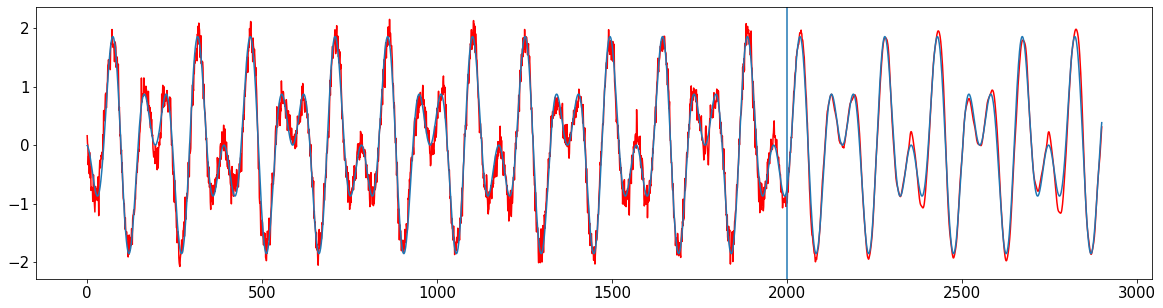

Error:  0.18521176
RMSE:  0.18521176


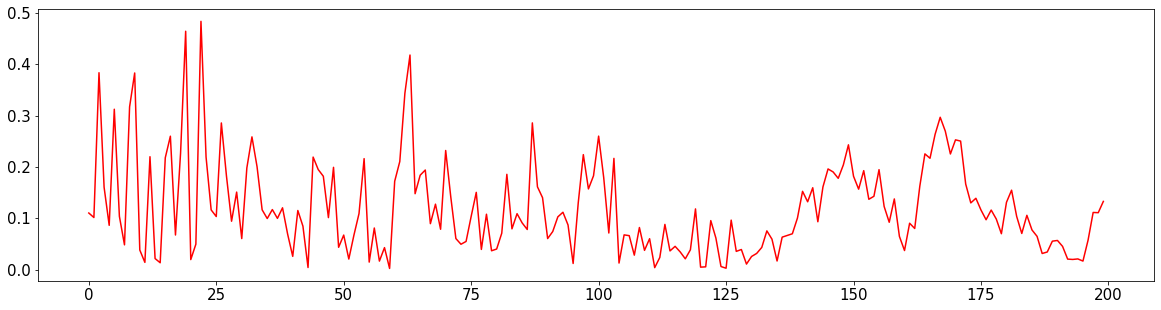

In [120]:
lrModels = []
lrTests = [0.003, 0.01, 0.03, 0.05, 0.08, 0.15, 0.3]

for l in lrTests:
    lrModels.append(train_neural_net(data=y, num_features=100, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=l, 
                 epochs=3, batches=3, min_batch_length=500, random_seed=100, print_results=True))

[(0.003, 0.79442406), (0.01, 0.45983008), (0.03, 0.28149188), (0.05, 0.28602645), (0.08, 0.28426453), (0.15, 0.35386044), (0.3, 0.34617344)]


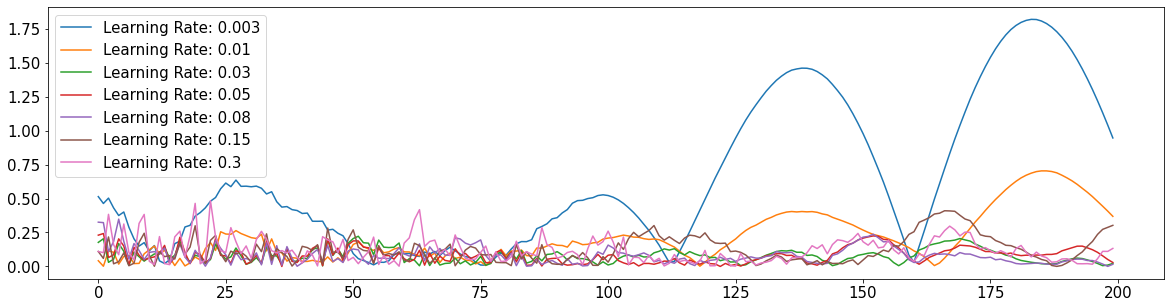

In [121]:
lrErrors = []

for m, s in zip(lrModels, lrTests):
    plt.plot(m["Future Errors"], label="Learning Rate: {}".format(str(s)))
    error = np.sqrt(np.mean(m["Future Errors"]))
    lrErrors.append((s, error))
    
print(lrErrors)
plt.legend(loc='upper left')
plt.show()

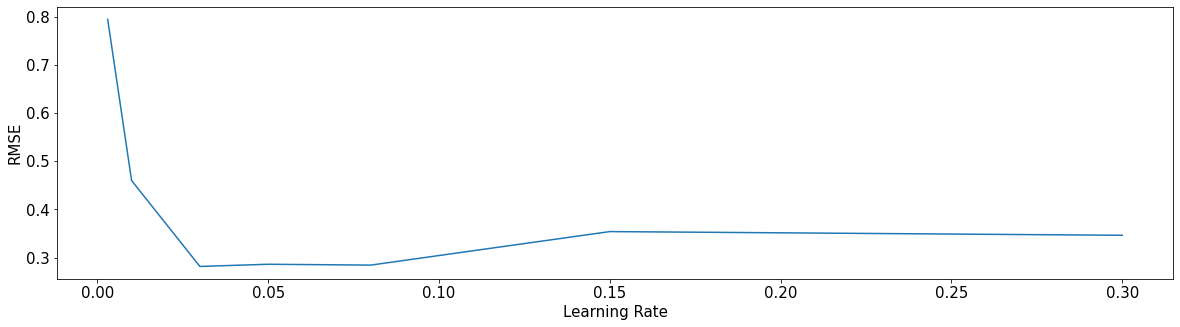

In [122]:
plt.plot([x[0] for x in lrErrors], [x[1] for x in lrErrors])
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.show()

1900 0
Epoch:  0 , Batch Indicies:  [0, 757, 1282, 1900]
Loss:  tensor(0.1822, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1530, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1345, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 564, 1137, 1900]
Loss:  tensor(0.1317, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1417, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1238, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 693, 1209, 1900]
Loss:  tensor(0.1302, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1235, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1316, grad_fn=<MseLossBackward0>)
Error:  0.13542008
RMSE:  0.13542008
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 3,
        Batches: 3, 
        Min Batch Size: 500,
        Random Seed: 100


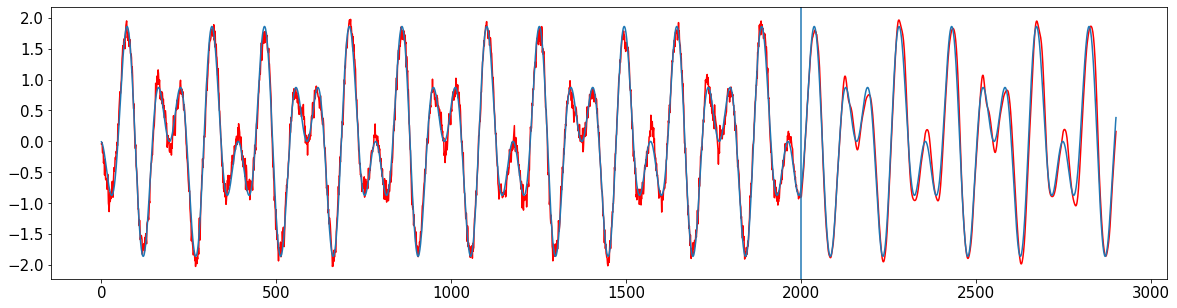

Error:  0.13542008
RMSE:  0.13542008


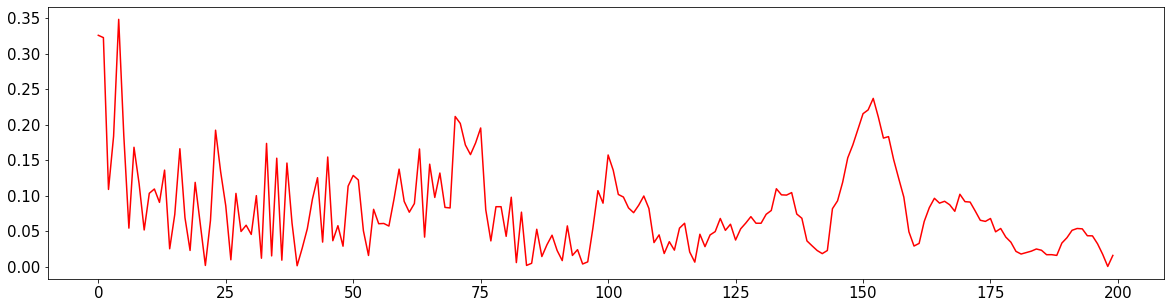

In [133]:
r3 = train_neural_net(data=y, num_features=100, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.08, 
                 epochs=3, batches=3, min_batch_length=500, random_seed=100, print_results=True)

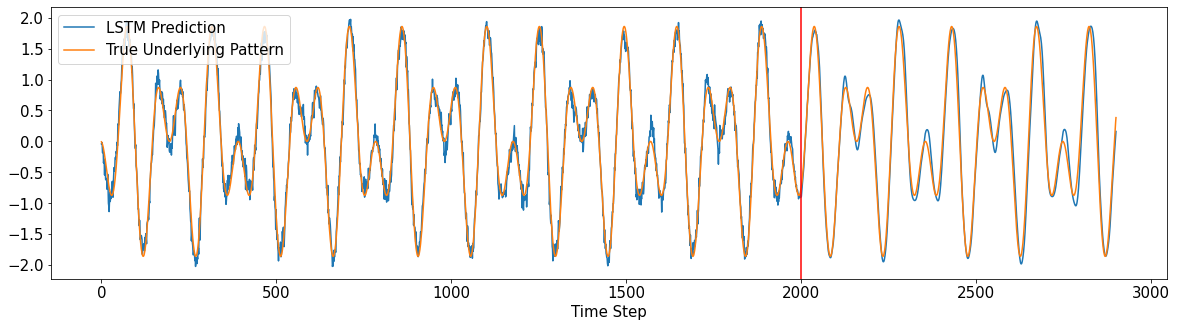

In [134]:
plt.plot(r3["Full Pred"], label="LSTM Prediction")
plt.plot(base_y[100:], label="True Underlying Pattern")
plt.axvline(x=len(y) - 1000, color="r")

plt.legend(loc='upper left')

plt.xlabel('Time Step')
plt.show()

In [143]:
np.random.seed(100)
random.seed(100)

N = 3000 # number of samples
# T1 = 20 # width of the wave
# M1 = 1

# T2 = 7
# M2 = 0.7

# T3 = 25
# M3 = 0.3

T1 = 150 # width of the wave
M1 = 1

T2 = 250
M2 = 1

T3 = 50
M3 = 0.3


stDev = 0.35 # Strength of noise
averageMovement = 4


x = np.arange(N) / N
base_y2 = np.sin(np.arange(N)*M1/T1*12).astype(np.float32)  \
       + np.sin(np.arange(N)*M2/T2*12).astype(np.float32) \
       + np.sin(np.arange(N)*M3/T3*12).astype(np.float32)
y2 = base_y2 + np.random.normal(loc=0, scale=stDev, size=N) # Add noise to sample

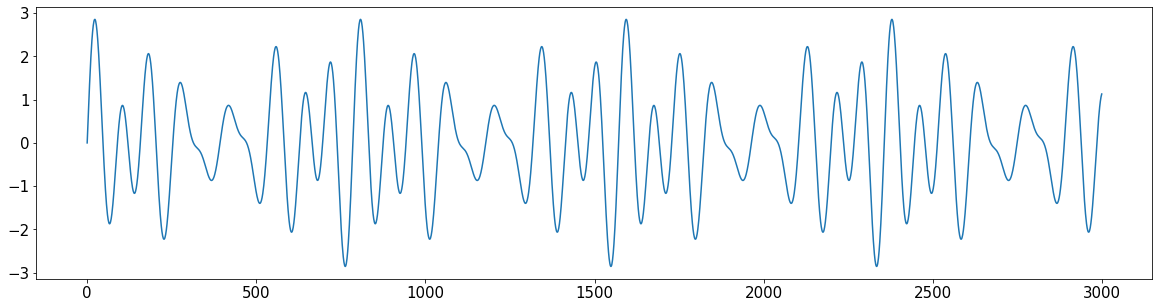

In [144]:
plt.plot(base_y2)

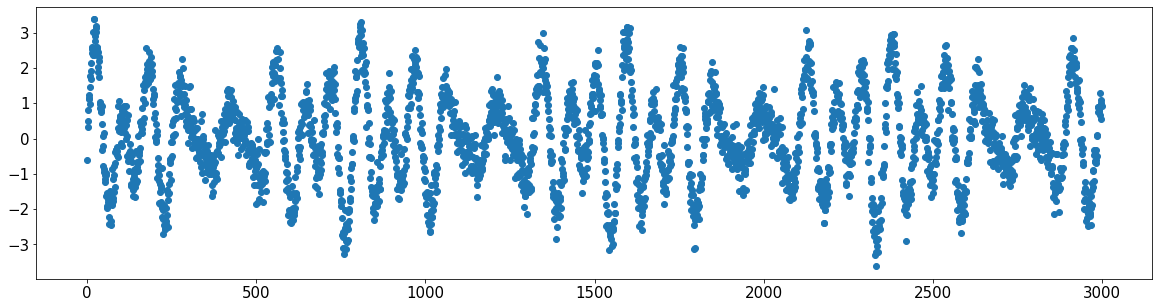

In [145]:
plt.scatter(np.arange(N), y2)

Epoch:  0 , Batch Indicies:  [0, 757, 1282, 1900]
Loss:  tensor(0.6459, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.3252, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1801, grad_fn=<MseLossBackward0>)
Epoch:  1 , Batch Indicies:  [0, 564, 1137, 1900]
Loss:  tensor(0.1865, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1645, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1673, grad_fn=<MseLossBackward0>)
Epoch:  2 , Batch Indicies:  [0, 693, 1209, 1900]
Loss:  tensor(0.1462, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1617, grad_fn=<MseLossBackward0>)
Loss:  tensor(0.1623, grad_fn=<MseLossBackward0>)
Error:  0.19086711
RMSE:  0.19086711
Features: 100,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.03,
        Epochs: 3,
        Batches: 3, 
        Min Batch Size: 500,
        Random Seed: 100


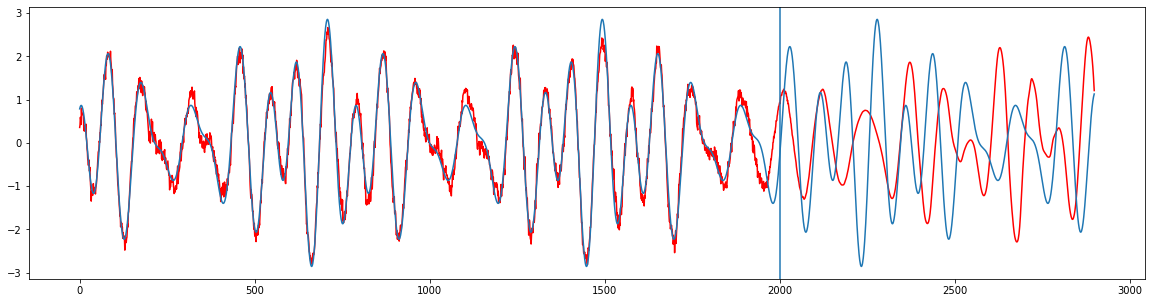

Error:  0.19086711
RMSE:  0.19086711


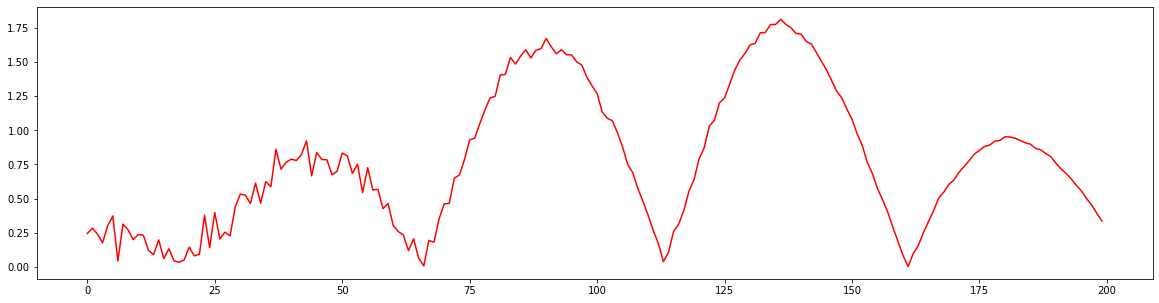

In [121]:
r = train_neural_net(data=y, num_features=100, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.03, 
                 epochs=3, batches=3, min_batch_length=500, random_seed=100, print_results=True)

In [ ]:
plt.plot(r["Full Pred"], label="LSTM Prediction")
plt.plot(base_y, label="Underlying Fourier Series")
plt.xlabel("Time Step")

plt.xlim(0, 3000)
plt.ylim(0, 3)
plt.show()

In [131]:
def training_loop_future(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target, 
                  num_batches=1, min_batch_length=100, future_preds=100, random_seed=100):
    """ Train a model with provided data
        Ignorning the auto plotting part for now """
    
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    for i in range(n_epochs):
        if num_batches > 1:
            while True:
                batchIndices = sorted([0] + [random.randint(0, len(train_input)) for x in range(num_batches)])
                min_batch = min([y-x for x, y in zip(batchIndices, batchIndices[1:]+[len(train_input)])])
                if min_batch >= min_batch_length:
                    break
            batches, batchY = [], []
            for n in range(num_batches):
                batches.append((train_input[batchIndices[n]:batchIndices[n+1]],
                                train_target[batchIndices[n]:batchIndices[n+1]]))
        else:
            batches = [(train_input, train_target)]
            batchIndices = None
        
        print("\nEpoch: ", i, ", Batch Indicies: ", batchIndices, end=": ")
        random.shuffle(batches)
        for x, y in batches:
            x = x[:-future_preds]
            y = y[-future_preds:]
            
            def closure():
                optimiser.zero_grad()
                out = model(x, future_preds=future_preds)
                out = out.reshape(out.shape[1])[-future_preds:]
                loss = loss_fn(out, y)
                loss.backward()
                model.last_loss = loss
                return loss
            
            optimiser.step(closure)
            print("Loss: ", model.last_loss.item(), end=", ")
        
        # Make future predictions
    if len(test_input) > 0:
        with torch.no_grad():
            future = len(test_target)
            pred = model(torch.cat([train_input, test_input], dim=0), future_preds=future)
            print(pred.shape)
            print(pred)
            loss = loss_fn(pred.reshape(pred.shape[1])[-future:], test_target)
            y = pred.detach().numpy()
    else:
        loss, y = None, None

    return (loss, y)

# num_features = 25
# num_samples = len(y)

# test_size = 0
# future_holdout = 1000

def train_neural_net_future(data, num_features, test_size, future_holdout, 
                     hidden_lstm_layers, criterion, optimiser, learning_rate, 
                     epochs, batches, min_batch_length, random_seed, print_results, future_preds):
    
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    num_samples = len(data)

    windowData = np.array(data[:num_features+1])
    for i in range(1, num_samples - num_features):
        windowData = np.vstack((windowData, data[i:i+num_features+1]))

    trainData = windowData[:-(test_size+future_holdout)]
    testData = windowData[-(test_size+future_holdout):-future_holdout]

    newTrainX = torch.tensor(trainData[:,:-1], dtype=torch.float32)
    newTrainY = torch.tensor(trainData[:,-1], dtype=torch.float32)

    newTestX = torch.tensor(testData[:,:-1], dtype=torch.float32)
    newTestY = torch.tensor(testData[:,-1], dtype=torch.float32)
    
    model = LSTM_multifeature(input_features=num_features, hidden_lstm_layers=hidden_lstm_layers)
    criterion = criterion
    optimiser =optimiser(model.parameters(), lr=learning_rate)
    
    # Train the model
    r = training_loop_future(epochs, model, optimiser, criterion, newTrainX, newTrainY, newTestX, newTestY, 
                                   num_batches=batches, min_batch_length=min_batch_length, random_seed=random_seed, future_preds=future_preds)

    with torch.no_grad():
        future = 1000
        pred = model(torch.cat([newTrainX, newTestX], dim=0), future_preds=future)
        # print(pred[0])
        bigPred = pred[0].detach().numpy()
    
    presentPred = bigPred[:-future_holdout]
    futurePred = bigPred[-future_holdout:]

    presentTrue = base_y[num_features:-future_holdout]
    futureTrue = base_y[-future_holdout:]

    error = np.sqrt(np.mean((presentPred - presentTrue)**2))
    print("Error: ", error)
    print("RMSE: ", RMSE(presentPred, presentTrue))

    futureErrorWindow = 200
    futureErrors = abs(futurePred[:futureErrorWindow] - futureTrue[:futureErrorWindow])
    
    results = {
        "Full Prediction" : bigPred,
        "RMSE" : error, 
        "FutureErrors" : futureErrors,
    }
    
    modelString = """Features: {},
        Future Holdout: {},
        Hidden Layers: {},
        Learning Rate: {},
        Epochs: {},
        Batches: {}, 
        Min Batch Size: {},
        Random Seed: {}""".format(
            num_features, future_holdout, "[" + ", ".join([str(x) for x in hidden_lstm_layers]) + "]", 
            learning_rate, epochs, batches, min_batch_length, random_seed)

    results = {
        "Desc" : modelString, 
        "Model" : model, 
        "Full Pred" : bigPred, 
        "Future Errors": futureErrors,
    }
    
    if print_results:
        print(modelString)
        
        plt.plot(bigPred, color="r")
        plt.plot(base_y[num_features:])
        # plt.axvline(x=900)
        plt.axvline(x=len(data) - future_holdout)
        plt.show()
        
        print("Error: ", error)
        print("RMSE: ", RMSE(presentPred, presentTrue))
        
        plt.plot(futureErrors, color="r")
        plt.show()
    
    return results


Epoch:  0 , Batch Indicies:  [0, 431, 839, 1282]: Loss:  0.11586127430200577, Loss:  0.11165747046470642, Loss:  0.08870679885149002, 
Epoch:  1 , Batch Indicies:  [0, 439, 853, 1289]: Loss:  0.10106761008501053, Loss:  0.09511572122573853, Loss:  0.10357724130153656, 
Epoch:  2 , Batch Indicies:  [0, 434, 851, 1290]: Loss:  0.06537152826786041, Loss:  0.06019429862499237, Loss:  0.09368156641721725, 
Epoch:  3 , Batch Indicies:  [0, 401, 802, 1279]: Loss:  0.09003657102584839, Loss:  0.07636963576078415, Loss:  0.10168328881263733, 
Epoch:  4 , Batch Indicies:  [0, 408, 810, 1267]: Loss:  0.08887962251901627, Loss:  0.08953069895505905, Loss:  0.09633433073759079, Error:  0.37231323
RMSE:  0.37231323
Features: 300,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 5,
        Batches: 3, 
        Min Batch Size: 400,
        Random Seed: 100


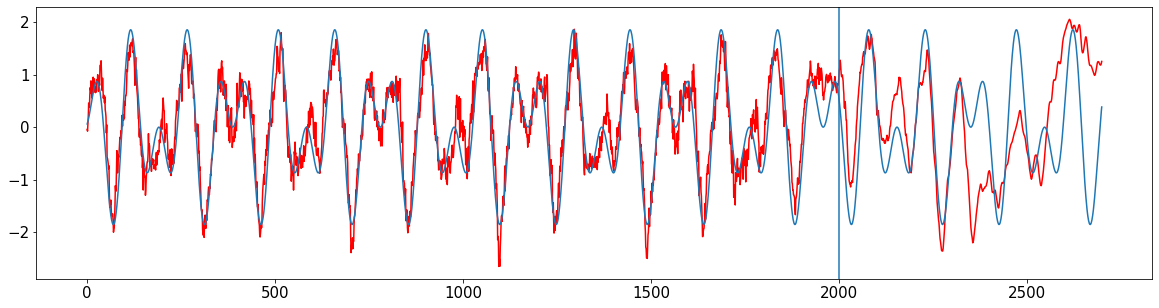

Error:  0.37231323
RMSE:  0.37231323


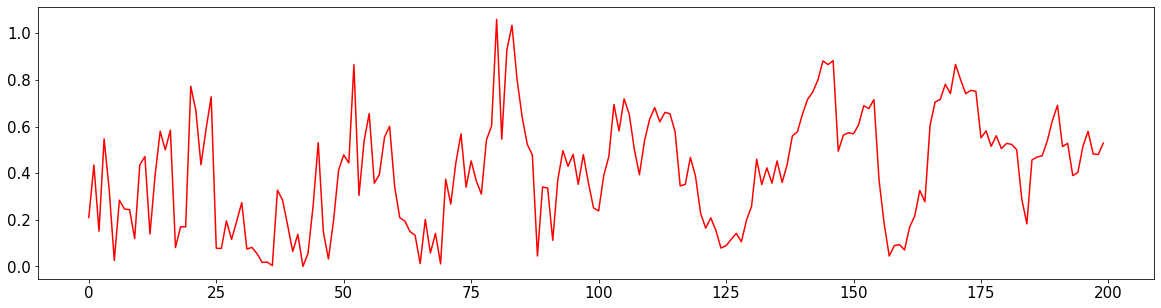

In [140]:
r5 = train_neural_net_future(data=y, num_features=300, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.08, 
                 epochs=5, batches=3, min_batch_length=400, random_seed=100, print_results=True, future_preds=100)


Epoch:  0 , Batch Indicies:  None: Loss:  0.5608928799629211, 
Epoch:  1 , Batch Indicies:  None: Loss:  0.145816832780838, 
Epoch:  2 , Batch Indicies:  None: Loss:  0.1265093833208084, 
Epoch:  3 , Batch Indicies:  None: Loss:  0.12175223976373672, Error:  0.11412961
RMSE:  0.11412961
Features: 300,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.08,
        Epochs: 4,
        Batches: 1, 
        Min Batch Size: 400,
        Random Seed: 100


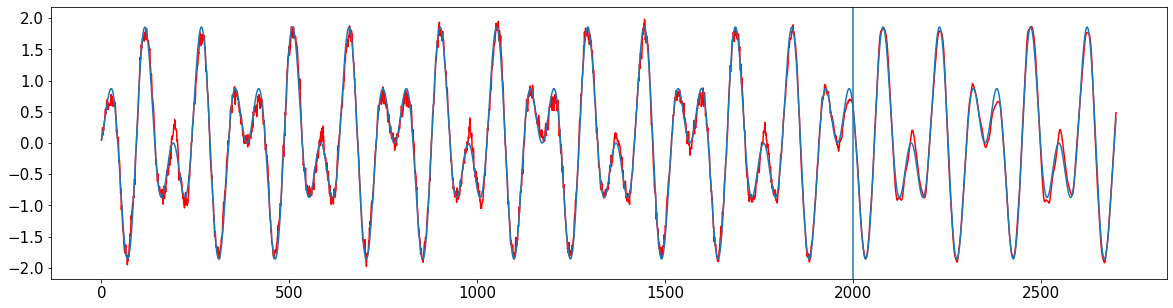

Error:  0.11412961
RMSE:  0.11412961


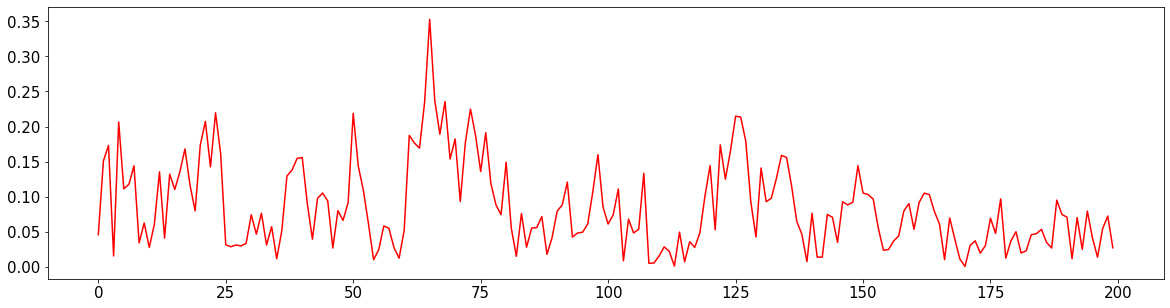

In [139]:
r4 = train_neural_net_future(data=y, num_features=300, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.08, 
                 epochs=4, batches=1, min_batch_length=400, random_seed=100, print_results=True, future_preds=1000)


Epoch:  0 , Batch Indicies:  None: Loss:  1.0181931257247925, 
Epoch:  1 , Batch Indicies:  None: Loss:  0.808841347694397, 
Epoch:  2 , Batch Indicies:  None: Loss:  0.7227920293807983, Error:  0.5874913
RMSE:  0.5874913
Features: 300,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.03,
        Epochs: 3,
        Batches: 1, 
        Min Batch Size: 600,
        Random Seed: 100


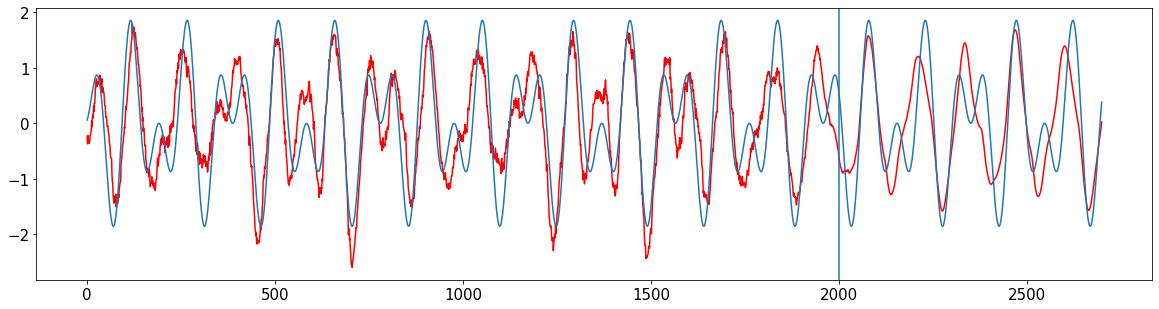

Error:  0.5874913
RMSE:  0.5874913


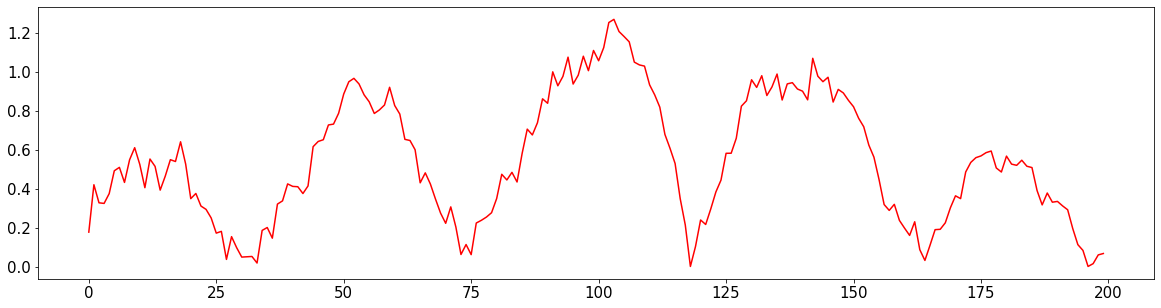

In [146]:
rc1 = train_neural_net_future(data=y2, num_features=300, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.03, 
                 epochs=3, batches=1, min_batch_length=600, random_seed=100, print_results=True, future_preds=1000)

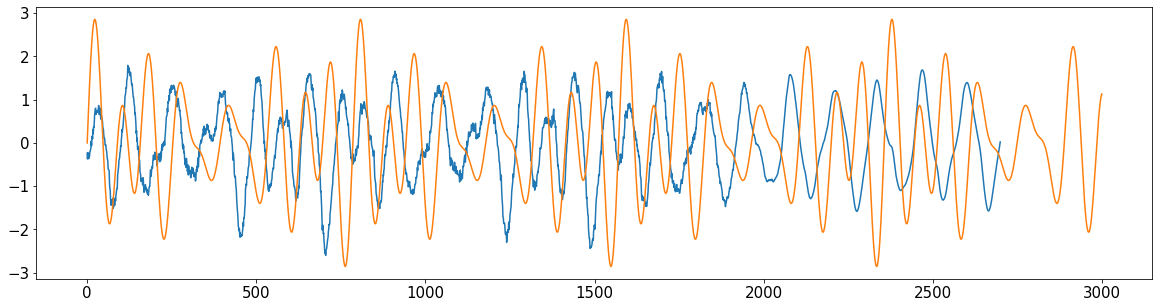

In [149]:
plt.plot(rc1["Full Pred"])
plt.plot(base_y2)


Epoch:  0 , Batch Indicies:  None: Loss:  1.4272011518478394, 
Epoch:  1 , Batch Indicies:  None: Loss:  0.8432956337928772, 
Epoch:  2 , Batch Indicies:  None: Loss:  0.7510381937026978, 
Epoch:  3 , Batch Indicies:  None: Loss:  0.7162396907806396, 
Epoch:  4 , Batch Indicies:  None: Loss:  0.6561658382415771, 
Epoch:  5 , Batch Indicies:  None: Loss:  0.3642429709434509, 
Epoch:  6 , Batch Indicies:  None: Loss:  0.2758428156375885, 
Epoch:  7 , Batch Indicies:  None: Loss:  0.23384690284729004, 
Epoch:  8 , Batch Indicies:  None: Loss:  0.20730692148208618, 
Epoch:  9 , Batch Indicies:  None: Loss:  0.18462327122688293, Error:  0.29112864
RMSE:  0.29112864
Features: 300,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.03,
        Epochs: 10,
        Batches: 1, 
        Min Batch Size: 600,
        Random Seed: 100


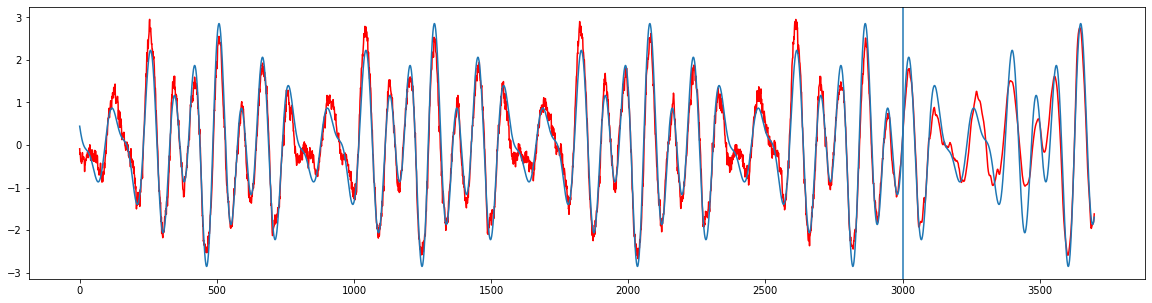

Error:  0.29112864
RMSE:  0.29112864


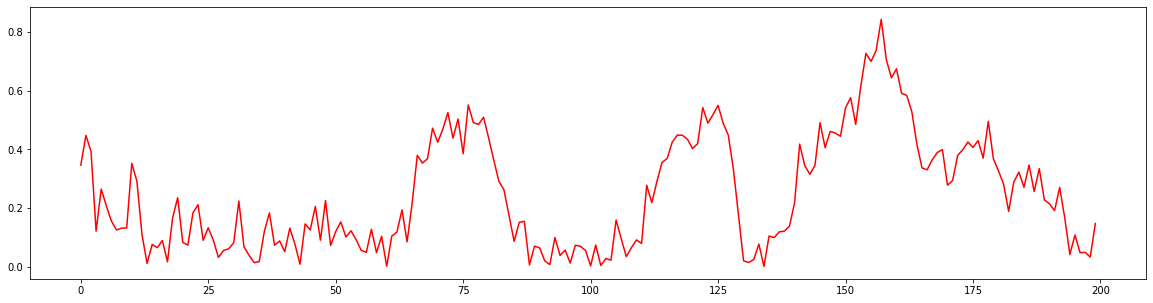

In [210]:
r2 = train_neural_net_future(data=y, num_features=300, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.03, 
                 epochs=10, batches=1, min_batch_length=600, random_seed=100, print_results=True, future_preds=1000)

In [ ]:
r2b = train_neural_net_future(data=y, num_features=100, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.08, 
                 epochs=5, batches=1, min_batch_length=600, random_seed=100, print_results=True, future_preds=1000)


Epoch:  0 , Batch Indicies:  None: Loss:  1.0752909183502197, 
Epoch:  1 , Batch Indicies:  None: Loss:  0.7644162774085999, 
Epoch:  2 , Batch Indicies:  None: Loss:  0.6421090364456177, 
Epoch:  3 , Batch Indicies:  None: 

In [156]:
print(len(y2))

3000


In [ ]:
r6 = train_neural_net_future(data=y2, num_features=100, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.03, 
                 epochs=, batches=3, min_batch_length=400, random_seed=100, print_results=True, future_preds=125)


Epoch:  0 , Batch Indicies:  None: Loss:  1.0181931257247925, 
Epoch:  1 , Batch Indicies:  None: Loss:  0.808841347694397, 
Epoch:  2 , Batch Indicies:  None: Loss:  0.7227920293807983, 
Epoch:  3 , Batch Indicies:  None: Loss:  0.6605333089828491, 
Epoch:  4 , Batch Indicies:  None: Loss:  0.5516731142997742, 
Epoch:  5 , Batch Indicies:  None: Loss:  0.4291912913322449, 
Epoch:  6 , Batch Indicies:  None: Loss:  0.3344195485115051, 
Epoch:  7 , Batch Indicies:  None: Loss:  0.2704286575317383, 
Epoch:  8 , Batch Indicies:  None: Loss:  0.22051654756069183, 
Epoch:  9 , Batch Indicies:  None: Loss:  0.20053309202194214, 
Epoch:  10 , Batch Indicies:  None: Loss:  0.17951318621635437, 
Epoch:  11 , Batch Indicies:  None: Loss:  0.16089977324008942, 
Epoch:  12 , Batch Indicies:  None: Loss:  0.1484064906835556, 
Epoch:  13 , Batch Indicies:  None: Loss:  0.135309100151062, 
Epoch:  14 , Batch Indicies:  None: Loss:  0.12913823127746582, Error:  0.71732676
RMSE:  0.71732676
Features: 

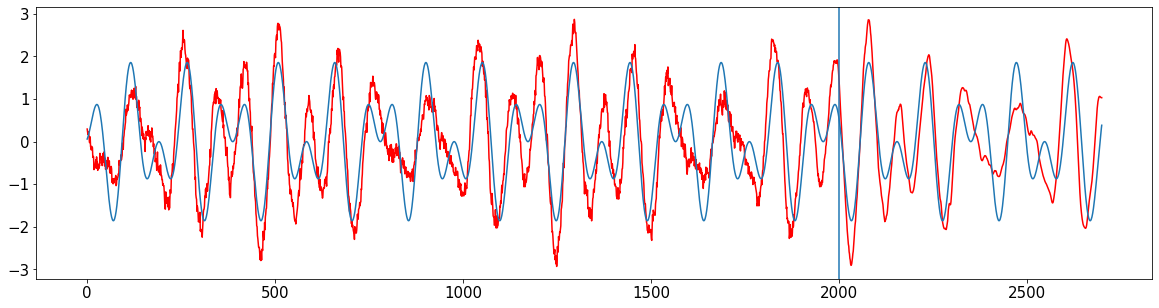

Error:  0.71732676
RMSE:  0.71732676


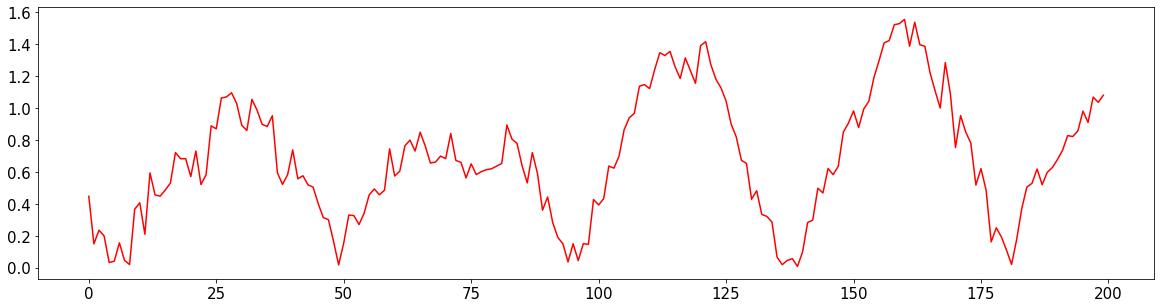

In [147]:
rc3 = train_neural_net_future(data=y2, num_features=300, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.03, 
                 epochs=15, batches=1, min_batch_length=600, random_seed=100, print_results=True, future_preds=1000)

In [208]:
np.random.seed(100)
random.seed(100)

N = 4000 # number of samples

T1 = 150 # width of the wave
M1 = 1

T2 = 250
M2 = 1

T3 = 50
M3 = 0.3


stDev = 0.35 # Strength of noise
averageMovement = 4


x = np.arange(N) / N
base_y = np.sin(np.arange(N)*M1/T1*12).astype(np.float32)  \
       + np.sin(np.arange(N)*M2/T2*12).astype(np.float32) \
       + np.sin(np.arange(N)*M3/T3*12).astype(np.float32)
y = base_y + np.random.normal(loc=0, scale=stDev, size=N) # Add noise to sample


Epoch:  0 , Batch Indicies:  None: Loss:  1.0928044319152832, 
Epoch:  1 , Batch Indicies:  None: Loss:  0.9548282623291016, 
Epoch:  2 , Batch Indicies:  None: Loss:  0.8755794763565063, 
Epoch:  3 , Batch Indicies:  None: Loss:  0.8113682270050049, 
Epoch:  4 , Batch Indicies:  None: Loss:  0.777644693851471, 
Epoch:  5 , Batch Indicies:  None: Loss:  0.7547792792320251, 
Epoch:  6 , Batch Indicies:  None: Loss:  0.6829473972320557, 
Epoch:  7 , Batch Indicies:  None: Loss:  0.6411969065666199, 
Epoch:  8 , Batch Indicies:  None: Loss:  0.571049690246582, 
Epoch:  9 , Batch Indicies:  None: Loss:  nan, Error:  nan
RMSE:  nan
Features: 200,
        Future Holdout: 1000,
        Hidden Layers: [128],
        Learning Rate: 0.03,
        Epochs: 10,
        Batches: 1, 
        Min Batch Size: 600,
        Random Seed: 100


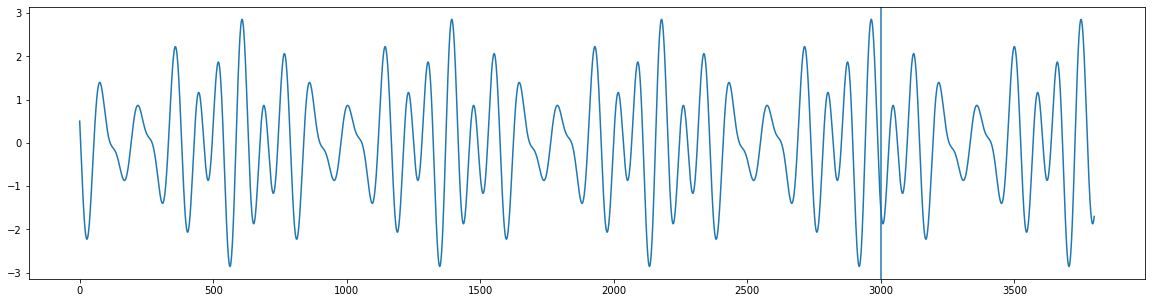

Error:  nan
RMSE:  nan


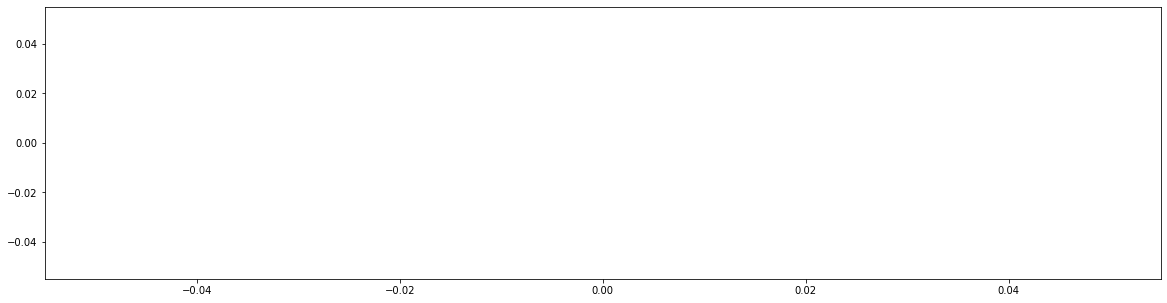

In [209]:
r2 = train_neural_net_future(data=y, num_features=200, test_size=0, future_holdout=1000, 
                 hidden_lstm_layers=[128], criterion=nn.MSELoss(), optimiser=torch.optim.LBFGS, learning_rate=0.03, 
                 epochs=10, batches=1, min_batch_length=600, random_seed=100, print_results=True, future_preds=1000)

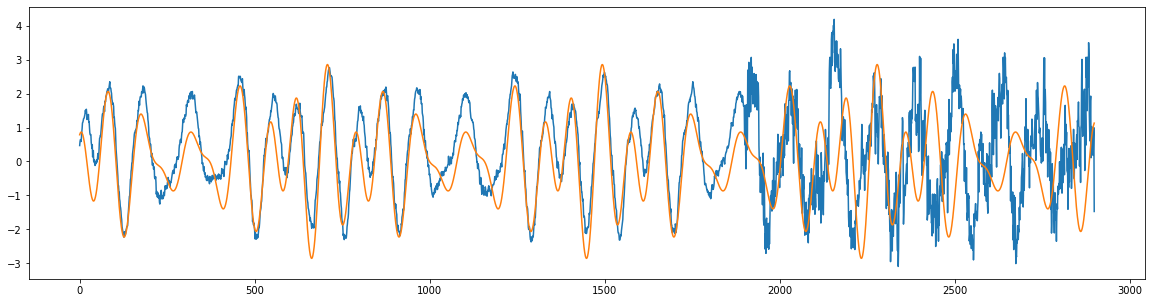

In [180]:
plt.plot(r2["Full Pred"]/5000000)
plt.plot(base_y[100:])

In [62]:
model = sm.tsa.arima.ARIMA(endog=np.array(y), order=(2, 0, 2), seasonal_order=(2, 0, 2, 700))
res = model.fit()
plt.plot(res.fittedvalues)

NameError: name 'sm' is not defined